# Vehicle Detection and Tracking Project

# Helper Section

In [138]:

# Imports

import numpy as np
import cv2
import glob # Used to read in image files of a particular pattern
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import random
import pickle
import collections # Used to store a recent window of good fits
import math # Used for nan detection
import sys # For progress indicator
import time # For time difference measurements

# SciKitLearn
from sklearn import datasets
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

# Packages below needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

from scipy.ndimage.measurements import label
from mpl_toolkits.mplot3d import Axes3D



In [2]:

# Shared Constants
# Constant for separating log statements( if needed )
const_separator_line = "--------------------------------"

# Constant representing a random seed for Data Splitting
const_data_split_seed = 42

# Constant representing location of the trained model
const_model_path = './model/model.pkl'

# Constants representing paths of test images
const_test_straight1 = './test_images/input/straight_lines1.jpg'
const_test_straight1_output = './test_images/output/straight_lines1.jpg'

const_test_straight2 = './test_images/input/straight_lines2.jpg'
const_test_straight2_output = './test_images/output/straight_lines2.jpg'

const_test_image_1 = './test_images/input/test1.jpg'
const_test_image_1_output = './test_images/output/test1.jpg'

const_test_image_2 = './test_images/input/test2.jpg'
const_test_image_2_output = './test_images/output/test2.jpg'

const_test_image_3 = './test_images/input/test3.jpg'
const_test_image_3_output = './test_images/output/test3.jpg'

const_test_image_4 = './test_images/input/test4.jpg'
const_test_image_4_output = './test_images/output/test4.jpg'

const_test_image_5 = './test_images/input/test5.jpg'
const_test_image_5_output = './test_images/output/test5.jpg'

const_test_image_6 = './test_images/input/test6.jpg'
const_test_image_6_output = './test_images/output/test6.jpg'

# Constants representing paths of a project video
const_project_video = './project_video/input/project_video.mp4'
const_project_video_output = './project_video/output/project_video_output.mp4'

# Constants representing paths of a test video
const_test_video = './test_video/input/test_video.mp4'
const_test_video_output = './test_video/output/test_video_output.mp4'

# Constants representing paths of model to train and test
## Non-Vehicles
nonvehicles_gti = glob.glob('./project_data/non-vehicles/GTI/image*.png')
nonvehicles_extras = glob.glob('./project_data/non-vehicles/Extras/extra*.png')

## Vehicles
vehicles_gti_far = glob.glob('./project_data/vehicles/GTI_Far/image*.png')
vehicles_gti_left = glob.glob('./project_data/vehicles/GTI_Left/image*.png')
vehicles_gti_middleclose = glob.glob('./project_data/vehicles/GTI_MiddleClose/image*.png')
vehicles_gti_right = glob.glob('./project_data/vehicles/GTI_Right/image*.png')
vehicles_gti_kitti = glob.glob('./project_data/vehicles/KITTI_extracted/*.png')



In [3]:

# Useful functions to selectively turn on / off logging at different levels

const_info_log_enabled = False
def infoLog(logMessage, param_separator=None):
    if const_info_log_enabled == True:
        print("")
        if param_separator:
            print(param_separator) 
        print(logMessage)

const_debug_log_enabled = True
def debugLog(logMessage, param_separator=None):
    if const_debug_log_enabled == True:
        print("")
        if param_separator:
            print(param_separator) 
        print(logMessage)
        
const_warning_log_enabled = True
def warningLog(logMessage, param_separator=None):
    if const_warning_log_enabled == True:
        print("")
        if param_separator:
            print(param_separator) 
        print(logMessage)
        
const_error_log_enabled = True
def errorLog(logMessage, param_separator=None):
    if const_error_log_enabled == True:
        print("")
        if param_separator:
            print(param_separator) 
        print(logMessage)


In [4]:

# Convenience function to show progress bar

def progressIndicator(count, total, suffix=''):
    bar_len = 60
    filled_len = int(round(bar_len * count / float(total)))

    percents = round(100.0 * count / float(total), 1)
    bar = '=' * filled_len + '-' * (bar_len - filled_len)

    sys.stdout.write('[%s] %s%s ...%s\r' % (bar, percents, '%', suffix))
    sys.stdout.flush()

In [5]:

# Convenience function for region of interest selection

def region_of_interest(img, vertices):

    # defining a blank mask to start with
    mask = np.zeros_like(img)

    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    region_of_interest_image = cv2.bitwise_and(img, mask)
    return region_of_interest_image


In [6]:

# Convenience function for reading an image from a path
# Provides a consistent read mechanism
# Returns an RGB image

def loadImageForPath(imagePath):
    image =  mpimg.imread(imagePath)
    return image



In [7]:

# Convenience function to get the scale ( min, max ) for an image 
def get_image_scale(imageOrPath, isImagePath = False):
    # If the image is a path, then read the image from Path
    image = None
    if(isImagePath == True):
        image = loadImageForPath(imageOrPath) # Reads image as an RGB image
    else:
        image = imageOrPath
        
    scale_min = np.amin(image)
    scale_max = np.amax(image)
    
    # Print out Image Scale
    infoLog("Image Scale - Min : " + str(scale_min))
    infoLog("Image Scale - Max : " + str(scale_max))

    return (scale_min, scale_max)


In [8]:

# Given a Feature vector

def describe_feature(feature, feature_label):
    desc_str = "Feature = " + feature_label
    debugLog("Exploring " + desc_str)
    debugLog("* Shape = " + str(feature.shape))
    debugLog("* Max value = " + str(np.amax(feature)))
    debugLog("* Min value = " + str(np.amin(feature)))



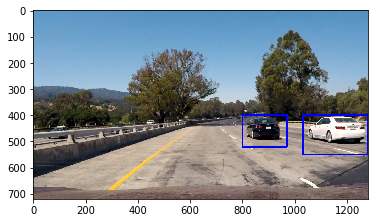

In [9]:

# Define a function that takes an image, a list of bounding boxes, 
# and optional color tuple and line thickness as inputs
# then draws boxes in that color on the output

def draw_boxes(imageOrPath, bboxes, color=(0, 0, 255), thick=6, isImagePath = False):
    
    # If the image is a path, then read the image from Path
    image = None
    if(isImagePath == True):
        image = loadImageForPath(imageOrPath) # Reads image as an RGB image
    else:
        image = imageOrPath
    
    # make a copy of the image
    draw_img = np.copy(image)
    # draw each bounding box on your image copy using cv2.rectangle()
    # return the image copy with boxes drawn
    for bbox in bboxes:
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    
    return draw_img # Change this line to return image copy with boxes

# Add bounding boxes in this format, these are just example coordinates.
bboxes = [((800, 400), (970, 520)), ((1030, 400), (1280, 550))]

result = draw_boxes(const_test_image_1, bboxes, color=(0, 0, 255), thick=6, isImagePath = True )
plt.imshow(result)


## Data Loading

In [10]:
# Confirm the fact that we were able to read the Testing / Training images properly

debugLog(len(nonvehicles_gti))
debugLog(len(nonvehicles_extras))

debugLog(len(vehicles_gti_far))
debugLog(len(vehicles_gti_left))
debugLog(len(vehicles_gti_middleclose))
debugLog(len(vehicles_gti_right))
debugLog(len(vehicles_gti_kitti))


debugLog("Total Number of Non Vehicle images : " + str(len(nonvehicles_gti) + len(nonvehicles_extras)))
debugLog("Total Number of Vehicle images : " + str(len(vehicles_gti_far) + len(vehicles_gti_left) + len(vehicles_gti_middleclose) + len(vehicles_gti_right) + len(vehicles_gti_kitti)))
debugLog("Therefore, it appears that the overall dataset is well-balanced, at least in terms of number of images")



3900

5068

834

909

419

664

5966

Total Number of Non Vehicle images : 8968

Total Number of Vehicle images : 8792

Therefore, it appears that the overall dataset is well-balanced, at least in terms of number of images


In [11]:

# Create a flattened array of Vehicle and Non-Vehicle Data

vehicles = vehicles_gti_far + vehicles_gti_left + vehicles_gti_middleclose + vehicles_gti_right + vehicles_gti_kitti
nonvehicles = nonvehicles_gti + nonvehicles_extras

# Assert one more time
debugLog("Total Number of Non Vehicle images : " + str(len(nonvehicles)))
debugLog("Total Number of Vehicle images : " + str(len(vehicles)))


# Dealloc unused data to reduce memory pressure
vehicles_gti_far = None
vehicles_gti_left = None
vehicles_gti_middleclose = None
vehicles_gti_right = None
vehicles_gti_kitti = None
nonvehicles_gti = None
nonvehicles_extras = None



Total Number of Non Vehicle images : 8968

Total Number of Vehicle images : 8792


In [12]:

# Create a consolidated Vehicle and non-Vehicle Data set

# Labels
y_nonvehicles = np.zeros(len(nonvehicles))
y_vehicles = np.ones(len(vehicles))
y = np.concatenate((y_nonvehicles, y_vehicles))

# Feature Paths
X_paths = nonvehicles + vehicles

# Ensure that the dimensions for the Features and the Labels match
debugLog("# Features : " + str(len(X_paths)))
debugLog("# Labels : " + str(len(y)))



# Features : 17760

# Labels : 17760


# Feature Extraction

In [13]:

# Extract Spatial Color features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features
    
# Pick a random image for visualization
image_index = random.randint(0, len(X_paths) - 1)
input_image_path = X_paths[image_index]
debugLog("Index is: " + str(image_index))

# binned_feature_vec = bin_spatial(input_image_path, color_space='RGB', size=(32, 32),isImagePath = True)

# # Plot features
# plt.plot(binned_feature_vec)
# plt.title('Spatially Binned Features')


# # Explore the Spatial Binned Features
# describe_feature(binned_feature_vec,"Spatially Binned")




Index is: 4039


In [14]:

# Extract HoG Features for the lower half of the image after grayscaling it
# Note that when we pass in 'feature_vec = True' we get back a flattened array of features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# # Define HOG parameters
# orient = 9
# pix_per_cell = 8
# cell_per_block = 2

# # Call our function with vis=True to see an image output
# hog_features, hog_image = get_hog_features(input_image_path, orient, 
#                         pix_per_cell, cell_per_block, 
#                         vis=True, feature_vec=True, isImagePath = True)

# # Plot the examples
# fig = plt.figure()
# plt.subplot(121)
# plt.imshow(loadImageForPath(input_image_path), cmap='gray')
# plt.title('Example Image')
# plt.subplot(122)
# plt.imshow(hog_image, cmap='gray')
# plt.title('HOG Visualization')

# # Explore the HoG Features
# describe_feature(hog_features,"HoG")


In [15]:
## Extract Color Features ( or HSV features ) for the lower half of the image

# Define a function to compute color histogram features  
# Note that I am not passing a scale range as a parameter, but instead calculating it dynamically
# This being done to automatically account for any differences in :
# 1. Loading with mpimg.imread versus cv2.imread, and
# 2. Loading .JPEG images versus .PNG images

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

calculated_bins_range = get_image_scale(input_image_path, True)

# rh, gh, bh, bincen, color_feature_vec = color_hist(input_image_path, nbins=32, isImagePath = True)

# # Plot a figure with all three bar charts
# if rh is not None:
#     fig = plt.figure(figsize=(12,3))
#     plt.subplot(131)
#     plt.bar(bincen, rh[0])
#     plt.xlim(scale_min, scale_max)
#     plt.title('R Histogram')
#     plt.subplot(132)
#     plt.bar(bincen, gh[0])
#     plt.xlim(scale_min, scale_max)
#     plt.title('G Histogram')
#     plt.subplot(133)
#     plt.bar(bincen, bh[0])
#     plt.xlim(scale_min, scale_max)
#     plt.title('B Histogram')
#     fig.tight_layout()
# else:
#     print('Your function is returning None for at least one variable...')

    
# # Explore the Color Feature
# describe_feature(color_feature_vec,"Color")

In [16]:

# Define a function to extract all relevant features from a list of images
# Have this function call bin_spatial() and color_hist() and get_hog_features()

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_size=(32, 32),
                        hist_bins=32):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
            
        hist_range = get_image_scale(feature_image)
        
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)


        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
#         features.append(hog_features)
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    return features



colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"

spatial = 32
histbin = 32

# Test extract_features
X_paths_small = X_paths[0:5]
X_features_small = extract_features(X_paths_small, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_size = (spatial, spatial), hist_bins = histbin)

# Inspect a single feature vector
X_feature_small = X_features_small[0]
debugLog("Shape of a single feature vector is : " +  str(X_feature_small.shape))
debugLog("Length of a single feature vector is : " +  str(len(X_feature_small)))



Shape of a single feature vector is : (4932,)

Length of a single feature vector is : 4932


In [17]:

# Run the feature extraction pipeline over the data set

# Reduce the sample size
sample_size = 1000
vehicles = vehicles[0 : sample_size]
nonvehicles = nonvehicles[0 : sample_size]

t=time.time()
vehicle_features = extract_features(vehicles, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_size = (spatial, spatial), hist_bins = histbin)

nonvehicle_features = extract_features(nonvehicles, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_size = (spatial, spatial), hist_bins = histbin)
t2 = time.time()
timediff = round(t2-t, 2)
debugLog( str(timediff) + ' seconds to extract features for ' + str(sample_size) + ' samples.' )




6.94 seconds to extract features for 1000 samples.


 # Data preparation ( for ML )

In [18]:

# Normalize the Features
# Create an array stack of feature vectors
# Ran into an issue : ValueError: setting an array element with a sequence.
# Solved with : https://stackoverflow.com/questions/19459017/how-to-convert-a-numpy-2d-array-with-object-dtype-to-a-regular-2d-array-of-float

X = np.vstack((vehicle_features, nonvehicle_features)).astype(np.float64) 

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)


In [19]:
# Define the labels vector
y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(nonvehicle_features))))



In [20]:

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)


## Train the Model ( Linear SVM )

In [21]:

# Reference - http://scikit-learn.org/stable/modules/svm.html#classification
# Additional reference - http://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html


In [22]:

# Perform the training

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

# Save the model for later
joblib.dump(svc, const_model_path)


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 4932
0.62 Seconds to train SVC...
Test Accuracy of SVC =  0.9875
My SVC predicts:  [ 1.  0.  0.  1.  0.  0.  1.  1.  0.  1.]
For these 10 labels:  [ 1.  0.  0.  1.  0.  0.  1.  1.  0.  1.]
0.00196 Seconds to predict 10 labels with SVC


['./model/model.pkl']

In [23]:

# Ensure we can restore the saved model and do a test prediction
# Model restoration example - http://scikit-learn.org/stable/modules/model_persistence.html

n_predict = 10
svc = joblib.load(const_model_path) 
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])



My SVC predicts:  [ 1.  0.  0.  1.  0.  0.  1.  1.  0.  1.]
For these 10 labels:  [ 1.  0.  0.  1.  0.  0.  1.  1.  0.  1.]


# Sliding Window Search


Image Color Scale : (0, 255)

Image Shape : (720, 1280, 3)


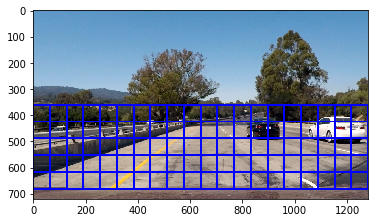

In [24]:

# Implement Sliding Window Search across the lower half of the image

image = loadImageForPath(const_test_image_1)
image_color_scale = get_image_scale(image)
debugLog("Image Color Scale : " + str(image_color_scale))
image_shape = image.shape
debugLog("Image Shape : " + str(image_shape))
image_width = image_shape[1]
image_height = image_shape[0]


def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

windows = slide_window(image, x_start_stop=[0, image_width], y_start_stop=[int(image_height/2), image_height], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)


# Prediction Vehicles and non-Vehicles for a given image

In [25]:

# For each Window we predict whether it is a Vehicle or not. Make sure that before predicting, you have applied
# The same types of preprocessing techniques to an image, as you did at the time of training !



Image Color Scale : (0, 255)

Image Shape : (720, 1280, 3)
Using: 9 orientations 8 pixels per cell and 2 cells per block  with sample size :  8000  and color space :  YCrCb
Feature vector length: 2580
0.13 Seconds to train SVC...
Test Accuracy of SVC =  0.985

(0.0, 3.0)

cars found
1


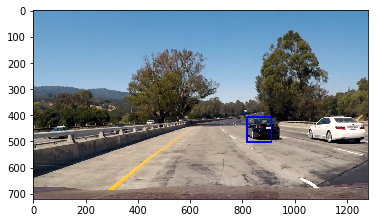

In [167]:

# Define an image to test
image = loadImageForPath(const_test_image_1)
image_color_scale = get_image_scale(image)
debugLog("Image Color Scale : " + str(image_color_scale))
image_shape = image.shape
debugLog("Image Shape : " + str(image_shape))
image_width = image_shape[1]
image_height = image_shape[0]
draw_image = np.copy(image)

# Reduce the sample size
sample_size = 8000
vehicles = vehicles[0 : sample_size]
nonvehicles = nonvehicles[0 : sample_size]

### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
param_x_start_stop = [0, image_width]
param_y_start_stop = [int(image_height/2), image_height] # Min and max in y to search in slide_window()
param_xy_window=(96, 96)
param_xy_overlap=(0.5, 0.5)
const_hot_threshold = 1 # Threshold to determine which section is 'hot'

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Getting the image scale dynamically, so that we can switch between png and jpg easily
    bins_range = get_image_scale(img)
    
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    
    
car_features = extract_features(vehicles, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(nonvehicles, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block', ' with sample size : ', sample_size, ' and color space : ', color_space  )
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()


# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=param_x_start_stop, y_start_stop=param_y_start_stop, 
                    xy_window=param_xy_window, xy_overlap=param_xy_overlap)

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

# plt.imshow(window_img)

# Todo - these are currently erroneous, and would have to be fixed by reviewing Chapter 37
# Applying Filtering for False Positive Removal and Duplicate Detections e.g. 400.0 is wrong

def add_heat(param_window_image, bbox_list):
    return_image = np.zeros_like(param_window_image[:,:,0]).astype(np.float)
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        return_image[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return return_image

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

heatmap = add_heat(draw_image, hot_windows)

heatmap_color_scale = get_image_scale(heatmap)
debugLog(heatmap_color_scale)

thresholded_heatmap = apply_threshold(heatmap, const_hot_threshold)
thresholded_heatmap = np.clip(thresholded_heatmap, 0, 255)

# plt.imshow(thresholded_heatmap, cmap = 'hot')

# Print out number of cars

labels = label(thresholded_heatmap)
debugLog(labels[1], 'cars found')
# plt.imshow(labels[0], cmap='gray')

def draw_labeled_bboxes(img, labels):
    return_image = np.copy(img)
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(return_image, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return return_image

# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(draw_image, labels)
# Display the image
plt.imshow(draw_img)




(0.0, 3.0)


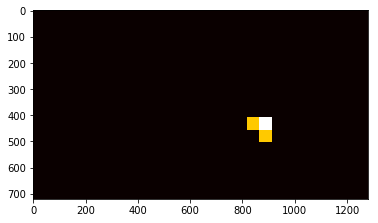

In [168]:

# Todo - these are currently erroneous, and would have to be fixed by reviewing Chapter 37
# Applying Filtering for False Positive Removal and Duplicate Detections e.g. 400.0 is wrong

def add_heat(param_window_image, bbox_list):
    return_image = np.zeros_like(param_window_image[:,:,0]).astype(np.float)
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        return_image[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return return_image

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

heatmap = add_heat(draw_image, hot_windows)

heatmap_color_scale = get_image_scale(heatmap)
debugLog(heatmap_color_scale)

thresholded_heatmap = apply_threshold(heatmap, const_hot_threshold)
thresholded_heatmap = np.clip(thresholded_heatmap, 0, 255)

plt.imshow(thresholded_heatmap, cmap = 'hot')




cars found
1


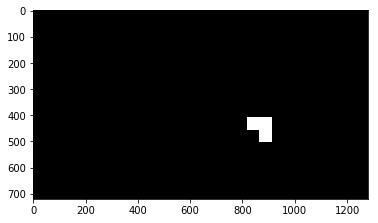

In [169]:

labels = label(thresholded_heatmap)
debugLog(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')


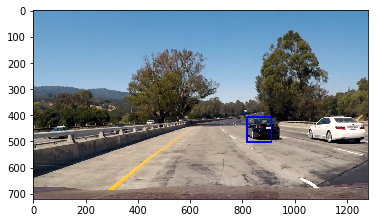

In [170]:

def draw_labeled_bboxes(img, labels):
    return_image = np.copy(img)
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(return_image, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return return_image

# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(draw_image, labels)
# Display the image
plt.imshow(draw_img)



# Immediate Next - 6/22/2017
      
* <B>Tweak the overall pipeline in a manner, that after FP and DD, the number of cars looks accurate.</B>
* Complete Chapter 35 - <B>Hog Sub-sampling Window Search</B>
* Need to improve false positive and duplicate detection.




# Done

* Complete Chapter 37 - <B>Multiple detections and false positives.</B>
* Update 'color_hist' so that hist_range / scale is computed dynamically for the image and isn't hard coded. Then run it again and view the results.
* Run the above algorithm on different images - all test images and view performance.
    * Ran the pipeline on different images and videos.
    * The false positive detection needs to be improved significantly, for the pipeline to be meaningful.
* Load an image from the Video, or from a sample video, and view and note the scale of that image (0,1) or (0,255)
    * Video images are of the scale (0,255)
* Run the training process for all 8000+ images to ensure model is fully trained. 
* Note down the list of parameters which you tried, and which ones gave the best results. 


In [171]:

# Whenever we find a Vehicle, we store it's vertices. Therefore, for each image, we would have an array of 
# vertices representing the Vehicles



In [172]:

# Implement some sort of False Positive rejection using Thresholding


## State preservation

In [173]:
# Clear history across the video pipeline

def reset_history():
    debugLog("Clearing any previous state.")
    


## Pipeline


Clearing any previous state.

Image scale is : (0, 255)

(0.0, 3.0)

cars found
1


True

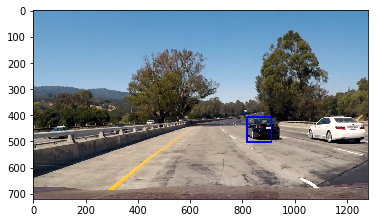

In [174]:

# Defining the pipeline

def pipeline(imageOrPath, isImagePath = False):

    # If the image is a path, then read the image from Path
    image = None
    if(isImagePath == True):
        image = mpimg.imread(imageOrPath) # Reads image as an RGB image
    else:
        image = imageOrPath

    # Clear out matplotlib plot frame for each run
    plt.clf()
        
    # Copy of the original image, on top of which we will draw the bounding boxes
    draw_image = np.copy(image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image_scale = get_image_scale(image)
    if image_scale[1] == 255:
        debugLog("Image scale is : " + str(image_scale) )
        image = image.astype(np.float32)/255

    image_shape = image.shape
    image_width = image_shape[1]
    image_height = image_shape[0]
    infoLog("Image Shape : " + str(image_shape))
        
    windows = slide_window(image, x_start_stop = param_x_start_stop, y_start_stop = param_y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    
    # Duplicate Detection and False Positive Rejection
    heatmap = add_heat(draw_image, hot_windows)
    debugLog(get_image_scale(heatmap))
    thresholded_heatmap = apply_threshold(heatmap, const_hot_threshold)
    labels = label(thresholded_heatmap)
    debugLog(labels[1], 'cars found')
    return_img = draw_labeled_bboxes(draw_image, labels)

    return return_img

reset_history()
combined_img = pipeline(const_test_image_1, True)
plt.imshow(combined_img)

cv2.imwrite(const_test_image_1_output, combined_img)



Clearing any previous state.

Image scale is : (0, 255)

(0.0, 2.0)

cars found
4


True

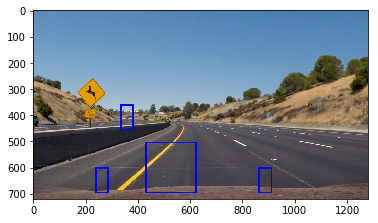

In [175]:

reset_history()
combined_img = pipeline(const_test_image_2, True)
plt.imshow(combined_img)

cv2.imwrite(const_test_image_2_output, combined_img)



Clearing any previous state.

Image scale is : (0, 255)

(0.0, 3.0)

cars found
4


True

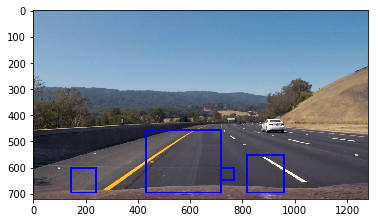

In [176]:


reset_history()
combined_img = pipeline(const_test_image_3, True)
plt.imshow(combined_img)

cv2.imwrite(const_test_image_3_output, combined_img)



Clearing any previous state.

Image scale is : (0, 255)

(0.0, 3.0)

cars found
4


True

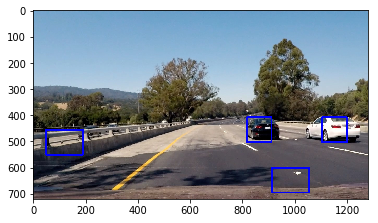

In [177]:


reset_history()
combined_img = pipeline(const_test_image_4, True)
plt.imshow(combined_img)

cv2.imwrite(const_test_image_4_output, combined_img)



Clearing any previous state.

Image scale is : (0, 255)

(0.0, 4.0)

cars found
5


True

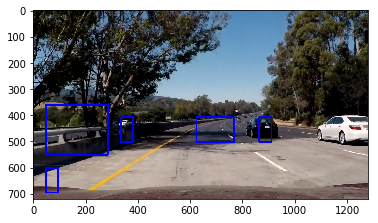

In [178]:

reset_history()
combined_img = pipeline(const_test_image_5, True)
plt.imshow(combined_img)

cv2.imwrite(const_test_image_5_output, combined_img)



Clearing any previous state.

Image scale is : (0, 255)

(0.0, 3.0)

cars found
5


True

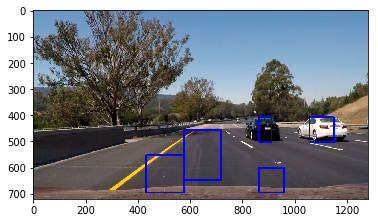

In [179]:

reset_history()
combined_img = pipeline(const_test_image_6, True)
plt.imshow(combined_img)

cv2.imwrite(const_test_image_5_output, combined_img)



Clearing any previous state.

Image scale is : (0, 255)

(0.0, 3.0)

cars found
3


True

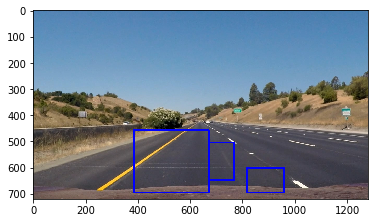

In [180]:

reset_history()
combined_img = pipeline(const_test_straight1, True)
plt.imshow(combined_img)

cv2.imwrite(const_test_straight1_output, combined_img)



Clearing any previous state.

Image scale is : (0, 255)

(0.0, 2.0)

cars found
5


True

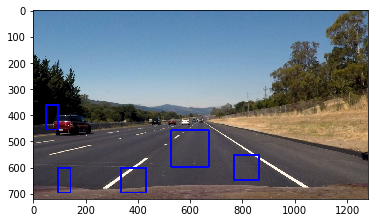

In [181]:

reset_history()
combined_img = pipeline(const_test_straight2, True)
plt.imshow(combined_img)

cv2.imwrite(const_test_straight2_output, combined_img)


In [136]:

# Pipeline as executed on the Test Video

reset_history()

clip1 = VideoFileClip(const_test_video)
output_clip1 = clip1.fl_image(pipeline)
output1 = const_test_video_output
%time output_clip1.write_videofile(output1, audio=False)



Clearing any previous state.

Image scale is : (0, 255)

(0.0, 3.0)

cars found
3
[MoviePy] >>>> Building video ./test_video/output/test_video_output.mp4
[MoviePy] Writing video ./test_video/output/test_video_output.mp4


  0%|          | 0/39 [00:00<?, ?it/s]


Image scale is : (0, 255)


  3%|▎         | 1/39 [00:00<00:12,  3.01it/s]


(0.0, 3.0)

cars found
3

Image scale is : (0, 255)


  5%|▌         | 2/39 [00:00<00:12,  2.96it/s]


(0.0, 3.0)

cars found
3

Image scale is : (0, 255)


  8%|▊         | 3/39 [00:01<00:12,  2.99it/s]


(0.0, 3.0)

cars found
3

Image scale is : (0, 255)


 10%|█         | 4/39 [00:01<00:11,  3.03it/s]


(0.0, 3.0)

cars found
2

Image scale is : (0, 255)


 13%|█▎        | 5/39 [00:01<00:11,  3.04it/s]


(0.0, 3.0)

cars found
3

Image scale is : (0, 255)


 15%|█▌        | 6/39 [00:01<00:10,  3.04it/s]


(0.0, 4.0)

cars found
2

Image scale is : (0, 255)


 18%|█▊        | 7/39 [00:02<00:10,  3.04it/s]


(0.0, 3.0)

cars found
5

Image scale is : (0, 255)


 21%|██        | 8/39 [00:02<00:10,  2.98it/s]


(0.0, 3.0)

cars found
3

Image scale is : (0, 255)


 23%|██▎       | 9/39 [00:03<00:10,  2.97it/s]


(0.0, 4.0)

cars found
3

Image scale is : (0, 255)


 26%|██▌       | 10/39 [00:03<00:09,  2.92it/s]


(0.0, 4.0)

cars found
4

Image scale is : (0, 255)


 28%|██▊       | 11/39 [00:03<00:09,  2.90it/s]


(0.0, 4.0)

cars found
4

Image scale is : (0, 255)


 31%|███       | 12/39 [00:04<00:09,  2.93it/s]


(0.0, 4.0)

cars found
1

Image scale is : (0, 255)


 33%|███▎      | 13/39 [00:04<00:08,  2.94it/s]


(0.0, 4.0)

cars found
3

Image scale is : (0, 255)


 36%|███▌      | 14/39 [00:04<00:08,  2.90it/s]


(0.0, 4.0)

cars found
1

Image scale is : (0, 255)


 38%|███▊      | 15/39 [00:05<00:08,  2.92it/s]


(0.0, 4.0)

cars found
4

Image scale is : (0, 255)


 41%|████      | 16/39 [00:05<00:08,  2.86it/s]


(0.0, 4.0)

cars found
5

Image scale is : (0, 255)


 44%|████▎     | 17/39 [00:05<00:07,  2.85it/s]


(0.0, 3.0)

cars found
4

Image scale is : (0, 255)


 46%|████▌     | 18/39 [00:06<00:07,  2.92it/s]


(0.0, 4.0)

cars found
2

Image scale is : (0, 255)


 49%|████▊     | 19/39 [00:06<00:06,  2.87it/s]


(0.0, 3.0)

cars found
4

Image scale is : (0, 255)


 51%|█████▏    | 20/39 [00:06<00:06,  2.85it/s]


(0.0, 4.0)

cars found
5

Image scale is : (0, 255)


 54%|█████▍    | 21/39 [00:07<00:06,  2.83it/s]


(0.0, 3.0)

cars found
6

Image scale is : (0, 255)


 56%|█████▋    | 22/39 [00:07<00:05,  2.83it/s]


(0.0, 4.0)

cars found
3

Image scale is : (0, 255)


 59%|█████▉    | 23/39 [00:07<00:05,  2.84it/s]


(0.0, 4.0)

cars found
6

Image scale is : (0, 255)


 62%|██████▏   | 24/39 [00:08<00:05,  2.84it/s]


(0.0, 4.0)

cars found
4

Image scale is : (0, 255)


 64%|██████▍   | 25/39 [00:08<00:04,  2.87it/s]


(0.0, 4.0)

cars found
4

Image scale is : (0, 255)


 67%|██████▋   | 26/39 [00:08<00:04,  2.86it/s]


(0.0, 4.0)

cars found
4

Image scale is : (0, 255)


 69%|██████▉   | 27/39 [00:09<00:04,  2.86it/s]


(0.0, 4.0)

cars found
5

Image scale is : (0, 255)


 72%|███████▏  | 28/39 [00:09<00:03,  2.81it/s]


(0.0, 4.0)

cars found
8

Image scale is : (0, 255)


 74%|███████▍  | 29/39 [00:10<00:03,  2.81it/s]


(0.0, 4.0)

cars found
5

Image scale is : (0, 255)


 77%|███████▋  | 30/39 [00:10<00:03,  2.85it/s]


(0.0, 4.0)

cars found
5

Image scale is : (0, 255)


 79%|███████▉  | 31/39 [00:10<00:02,  2.89it/s]


(0.0, 3.0)

cars found
2

Image scale is : (0, 255)


 82%|████████▏ | 32/39 [00:11<00:02,  2.89it/s]


(0.0, 3.0)

cars found
2

Image scale is : (0, 255)


 85%|████████▍ | 33/39 [00:11<00:02,  2.87it/s]


(0.0, 4.0)

cars found
4

Image scale is : (0, 255)


 87%|████████▋ | 34/39 [00:11<00:01,  2.86it/s]


(0.0, 4.0)

cars found
3

Image scale is : (0, 255)


 90%|████████▉ | 35/39 [00:12<00:01,  2.86it/s]


(0.0, 4.0)

cars found
5

Image scale is : (0, 255)


 92%|█████████▏| 36/39 [00:12<00:01,  2.89it/s]


(0.0, 4.0)

cars found
3

Image scale is : (0, 255)


 95%|█████████▍| 37/39 [00:12<00:00,  2.95it/s]


(0.0, 3.0)

cars found
1

Image scale is : (0, 255)


 97%|█████████▋| 38/39 [00:13<00:00,  3.02it/s]


(0.0, 4.0)

cars found
2


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_video/output/test_video_output.mp4 

CPU times: user 12.6 s, sys: 0 ns, total: 12.6 s
Wall time: 16.4 s


In [94]:

# Pipeline as executed on the Project Video

reset_history()

clip2 = VideoFileClip(const_project_video)
output_clip2 = clip2.fl_image(pipeline)
output2 = const_project_video_output
%time output_clip2.write_videofile(output2, audio=False)



Clearing any previous state.

Image scale is : (0, 255)
[MoviePy] >>>> Building video ./project_video/output/project_video_output.mp4
[MoviePy] Writing video ./project_video/output/project_video_output.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]


Image scale is : (0, 255)


  0%|          | 1/1261 [00:00<06:12,  3.38it/s]


Image scale is : (0, 255)


  0%|          | 2/1261 [00:00<06:18,  3.32it/s]


Image scale is : (0, 255)


  0%|          | 3/1261 [00:00<06:15,  3.35it/s]


Image scale is : (0, 255)


  0%|          | 4/1261 [00:01<06:12,  3.38it/s]


Image scale is : (0, 255)


  0%|          | 5/1261 [00:01<06:10,  3.39it/s]


Image scale is : (0, 255)


  0%|          | 6/1261 [00:01<06:15,  3.34it/s]


Image scale is : (0, 255)


  1%|          | 7/1261 [00:02<06:21,  3.29it/s]


Image scale is : (0, 255)


  1%|          | 8/1261 [00:02<06:22,  3.27it/s]


Image scale is : (0, 255)


  1%|          | 9/1261 [00:02<06:23,  3.27it/s]


Image scale is : (0, 255)


  1%|          | 10/1261 [00:03<06:27,  3.23it/s]


Image scale is : (0, 255)


  1%|          | 11/1261 [00:03<06:25,  3.24it/s]


Image scale is : (0, 255)


  1%|          | 12/1261 [00:03<06:31,  3.19it/s]


Image scale is : (0, 255)


  1%|          | 13/1261 [00:03<06:26,  3.23it/s]


Image scale is : (0, 255)


  1%|          | 14/1261 [00:04<06:21,  3.27it/s]


Image scale is : (0, 255)


  1%|          | 15/1261 [00:04<06:22,  3.26it/s]


Image scale is : (0, 255)


  1%|▏         | 16/1261 [00:04<06:17,  3.30it/s]


Image scale is : (0, 255)


  1%|▏         | 17/1261 [00:05<06:20,  3.27it/s]


Image scale is : (0, 255)


  1%|▏         | 18/1261 [00:05<06:22,  3.25it/s]


Image scale is : (0, 255)


  2%|▏         | 19/1261 [00:05<06:16,  3.30it/s]


Image scale is : (0, 255)


  2%|▏         | 20/1261 [00:06<06:22,  3.24it/s]


Image scale is : (0, 255)


  2%|▏         | 21/1261 [00:06<06:25,  3.22it/s]


Image scale is : (0, 255)


  2%|▏         | 22/1261 [00:06<06:29,  3.18it/s]


Image scale is : (0, 255)


  2%|▏         | 23/1261 [00:07<06:30,  3.17it/s]


Image scale is : (0, 255)


  2%|▏         | 24/1261 [00:07<06:28,  3.18it/s]


Image scale is : (0, 255)


  2%|▏         | 25/1261 [00:07<06:27,  3.19it/s]


Image scale is : (0, 255)


  2%|▏         | 26/1261 [00:07<06:19,  3.25it/s]


Image scale is : (0, 255)


  2%|▏         | 27/1261 [00:08<06:14,  3.29it/s]


Image scale is : (0, 255)


  2%|▏         | 28/1261 [00:08<06:09,  3.34it/s]


Image scale is : (0, 255)


  2%|▏         | 29/1261 [00:08<06:04,  3.38it/s]


Image scale is : (0, 255)


  2%|▏         | 30/1261 [00:09<06:10,  3.33it/s]


Image scale is : (0, 255)


  2%|▏         | 31/1261 [00:09<06:04,  3.38it/s]


Image scale is : (0, 255)


  3%|▎         | 32/1261 [00:09<05:59,  3.41it/s]


Image scale is : (0, 255)


  3%|▎         | 33/1261 [00:10<05:55,  3.45it/s]


Image scale is : (0, 255)


  3%|▎         | 34/1261 [00:10<05:56,  3.44it/s]


Image scale is : (0, 255)


  3%|▎         | 35/1261 [00:10<05:54,  3.46it/s]


Image scale is : (0, 255)


  3%|▎         | 36/1261 [00:10<05:55,  3.45it/s]


Image scale is : (0, 255)


  3%|▎         | 37/1261 [00:11<05:55,  3.45it/s]


Image scale is : (0, 255)


  3%|▎         | 38/1261 [00:11<05:53,  3.46it/s]


Image scale is : (0, 255)


  3%|▎         | 39/1261 [00:11<05:50,  3.49it/s]


Image scale is : (0, 255)


  3%|▎         | 40/1261 [00:12<05:54,  3.45it/s]


Image scale is : (0, 255)


  3%|▎         | 41/1261 [00:12<05:53,  3.45it/s]


Image scale is : (0, 255)


  3%|▎         | 42/1261 [00:12<05:52,  3.46it/s]


Image scale is : (0, 255)


  3%|▎         | 43/1261 [00:13<07:30,  2.71it/s]


Image scale is : (0, 255)


  3%|▎         | 44/1261 [00:13<07:25,  2.73it/s]


Image scale is : (0, 255)


  4%|▎         | 45/1261 [00:13<07:13,  2.81it/s]


Image scale is : (0, 255)


  4%|▎         | 46/1261 [00:14<07:07,  2.84it/s]


Image scale is : (0, 255)


  4%|▎         | 47/1261 [00:14<07:12,  2.81it/s]


Image scale is : (0, 255)


  4%|▍         | 48/1261 [00:14<07:07,  2.84it/s]


Image scale is : (0, 255)


  4%|▍         | 49/1261 [00:15<07:20,  2.75it/s]


Image scale is : (0, 255)


  4%|▍         | 50/1261 [00:15<07:28,  2.70it/s]


Image scale is : (0, 255)


  4%|▍         | 51/1261 [00:16<07:24,  2.72it/s]


Image scale is : (0, 255)


  4%|▍         | 52/1261 [00:16<07:15,  2.78it/s]


Image scale is : (0, 255)


  4%|▍         | 53/1261 [00:16<07:28,  2.69it/s]


Image scale is : (0, 255)


  4%|▍         | 54/1261 [00:17<07:24,  2.71it/s]


Image scale is : (0, 255)


  4%|▍         | 55/1261 [00:17<07:17,  2.76it/s]


Image scale is : (0, 255)


  4%|▍         | 56/1261 [00:17<07:07,  2.82it/s]


Image scale is : (0, 255)


  5%|▍         | 57/1261 [00:18<07:24,  2.71it/s]


Image scale is : (0, 255)


  5%|▍         | 58/1261 [00:18<07:25,  2.70it/s]


Image scale is : (0, 255)


  5%|▍         | 59/1261 [00:18<07:13,  2.78it/s]


Image scale is : (0, 255)


  5%|▍         | 60/1261 [00:19<07:09,  2.79it/s]


Image scale is : (0, 255)


  5%|▍         | 61/1261 [00:19<07:23,  2.71it/s]


Image scale is : (0, 255)


  5%|▍         | 62/1261 [00:20<07:24,  2.70it/s]


Image scale is : (0, 255)


  5%|▍         | 63/1261 [00:20<07:19,  2.73it/s]


Image scale is : (0, 255)


  5%|▌         | 64/1261 [00:20<07:42,  2.59it/s]


Image scale is : (0, 255)


  5%|▌         | 65/1261 [00:21<07:42,  2.59it/s]


Image scale is : (0, 255)


  5%|▌         | 66/1261 [00:21<07:33,  2.63it/s]


Image scale is : (0, 255)


  5%|▌         | 67/1261 [00:21<07:19,  2.72it/s]


Image scale is : (0, 255)


  5%|▌         | 68/1261 [00:22<07:39,  2.60it/s]


Image scale is : (0, 255)


  5%|▌         | 69/1261 [00:22<07:33,  2.63it/s]


Image scale is : (0, 255)


  6%|▌         | 70/1261 [00:23<07:16,  2.73it/s]


Image scale is : (0, 255)


  6%|▌         | 71/1261 [00:23<07:08,  2.77it/s]


Image scale is : (0, 255)


  6%|▌         | 72/1261 [00:23<07:34,  2.62it/s]


Image scale is : (0, 255)


  6%|▌         | 73/1261 [00:24<07:40,  2.58it/s]


Image scale is : (0, 255)


  6%|▌         | 74/1261 [00:24<07:34,  2.61it/s]


Image scale is : (0, 255)


  6%|▌         | 75/1261 [00:24<07:17,  2.71it/s]


Image scale is : (0, 255)


  6%|▌         | 76/1261 [00:25<07:31,  2.63it/s]


Image scale is : (0, 255)


  6%|▌         | 77/1261 [00:25<07:19,  2.69it/s]


Image scale is : (0, 255)


  6%|▌         | 78/1261 [00:26<07:22,  2.67it/s]


Image scale is : (0, 255)


  6%|▋         | 79/1261 [00:26<07:17,  2.70it/s]


Image scale is : (0, 255)


  6%|▋         | 80/1261 [00:26<07:07,  2.76it/s]


Image scale is : (0, 255)


  6%|▋         | 81/1261 [00:27<07:05,  2.77it/s]


Image scale is : (0, 255)


  7%|▋         | 82/1261 [00:27<07:23,  2.66it/s]


Image scale is : (0, 255)


  7%|▋         | 83/1261 [00:28<07:52,  2.50it/s]


Image scale is : (0, 255)


  7%|▋         | 84/1261 [00:28<07:57,  2.46it/s]


Image scale is : (0, 255)


  7%|▋         | 85/1261 [00:28<08:06,  2.42it/s]


Image scale is : (0, 255)


  7%|▋         | 86/1261 [00:29<07:48,  2.51it/s]


Image scale is : (0, 255)


  7%|▋         | 87/1261 [00:29<07:29,  2.61it/s]


Image scale is : (0, 255)


  7%|▋         | 88/1261 [00:29<07:15,  2.70it/s]


Image scale is : (0, 255)


  7%|▋         | 89/1261 [00:30<07:23,  2.64it/s]


Image scale is : (0, 255)


  7%|▋         | 90/1261 [00:30<07:21,  2.65it/s]


Image scale is : (0, 255)


  7%|▋         | 91/1261 [00:31<07:10,  2.72it/s]


Image scale is : (0, 255)


  7%|▋         | 92/1261 [00:31<07:15,  2.68it/s]


Image scale is : (0, 255)


  7%|▋         | 93/1261 [00:31<07:09,  2.72it/s]


Image scale is : (0, 255)


  7%|▋         | 94/1261 [00:32<06:59,  2.78it/s]


Image scale is : (0, 255)


  8%|▊         | 95/1261 [00:32<07:07,  2.73it/s]


Image scale is : (0, 255)


  8%|▊         | 96/1261 [00:32<07:00,  2.77it/s]


Image scale is : (0, 255)


  8%|▊         | 97/1261 [00:33<07:04,  2.74it/s]


Image scale is : (0, 255)


  8%|▊         | 98/1261 [00:33<07:18,  2.65it/s]


Image scale is : (0, 255)


  8%|▊         | 99/1261 [00:34<07:08,  2.71it/s]


Image scale is : (0, 255)


  8%|▊         | 100/1261 [00:34<06:58,  2.77it/s]


Image scale is : (0, 255)


  8%|▊         | 101/1261 [00:34<07:12,  2.68it/s]


Image scale is : (0, 255)


  8%|▊         | 102/1261 [00:35<07:06,  2.72it/s]


Image scale is : (0, 255)


  8%|▊         | 103/1261 [00:35<06:54,  2.79it/s]


Image scale is : (0, 255)


  8%|▊         | 104/1261 [00:35<06:50,  2.82it/s]


Image scale is : (0, 255)


  8%|▊         | 105/1261 [00:36<07:03,  2.73it/s]


Image scale is : (0, 255)


  8%|▊         | 106/1261 [00:36<07:00,  2.75it/s]


Image scale is : (0, 255)


  8%|▊         | 107/1261 [00:36<06:50,  2.81it/s]


Image scale is : (0, 255)


  9%|▊         | 108/1261 [00:37<06:44,  2.85it/s]


Image scale is : (0, 255)


  9%|▊         | 109/1261 [00:37<07:01,  2.73it/s]


Image scale is : (0, 255)


  9%|▊         | 110/1261 [00:37<06:56,  2.76it/s]


Image scale is : (0, 255)


  9%|▉         | 111/1261 [00:38<06:44,  2.84it/s]


Image scale is : (0, 255)


  9%|▉         | 112/1261 [00:38<06:57,  2.75it/s]


Image scale is : (0, 255)


  9%|▉         | 113/1261 [00:39<06:48,  2.81it/s]


Image scale is : (0, 255)


  9%|▉         | 114/1261 [00:39<07:01,  2.72it/s]


Image scale is : (0, 255)


  9%|▉         | 115/1261 [00:39<06:57,  2.75it/s]


Image scale is : (0, 255)


  9%|▉         | 116/1261 [00:40<06:52,  2.78it/s]


Image scale is : (0, 255)


  9%|▉         | 117/1261 [00:40<06:46,  2.82it/s]


Image scale is : (0, 255)


  9%|▉         | 118/1261 [00:40<06:59,  2.72it/s]


Image scale is : (0, 255)


  9%|▉         | 119/1261 [00:41<06:57,  2.73it/s]


Image scale is : (0, 255)


 10%|▉         | 120/1261 [00:41<06:51,  2.77it/s]


Image scale is : (0, 255)


 10%|▉         | 121/1261 [00:41<06:41,  2.84it/s]


Image scale is : (0, 255)


 10%|▉         | 122/1261 [00:42<06:57,  2.73it/s]


Image scale is : (0, 255)


 10%|▉         | 123/1261 [00:42<06:56,  2.73it/s]


Image scale is : (0, 255)


 10%|▉         | 124/1261 [00:43<06:47,  2.79it/s]


Image scale is : (0, 255)


 10%|▉         | 125/1261 [00:43<06:40,  2.83it/s]


Image scale is : (0, 255)


 10%|▉         | 126/1261 [00:43<06:57,  2.72it/s]


Image scale is : (0, 255)


 10%|█         | 127/1261 [00:44<06:56,  2.72it/s]


Image scale is : (0, 255)


 10%|█         | 128/1261 [00:44<06:50,  2.76it/s]


Image scale is : (0, 255)


 10%|█         | 129/1261 [00:44<06:53,  2.74it/s]


Image scale is : (0, 255)


 10%|█         | 130/1261 [00:45<07:14,  2.60it/s]


Image scale is : (0, 255)


 10%|█         | 131/1261 [00:45<07:13,  2.60it/s]


Image scale is : (0, 255)


 10%|█         | 132/1261 [00:45<06:55,  2.72it/s]


Image scale is : (0, 255)


 11%|█         | 133/1261 [00:46<06:51,  2.74it/s]


Image scale is : (0, 255)


 11%|█         | 134/1261 [00:46<07:13,  2.60it/s]


Image scale is : (0, 255)


 11%|█         | 135/1261 [00:47<07:11,  2.61it/s]


Image scale is : (0, 255)


 11%|█         | 136/1261 [00:47<07:02,  2.66it/s]


Image scale is : (0, 255)


 11%|█         | 137/1261 [00:47<06:50,  2.74it/s]


Image scale is : (0, 255)


 11%|█         | 138/1261 [00:48<07:12,  2.60it/s]


Image scale is : (0, 255)


 11%|█         | 139/1261 [00:48<07:04,  2.65it/s]


Image scale is : (0, 255)


 11%|█         | 140/1261 [00:48<06:47,  2.75it/s]


Image scale is : (0, 255)


 11%|█         | 141/1261 [00:49<06:41,  2.79it/s]


Image scale is : (0, 255)


 11%|█▏        | 142/1261 [00:49<06:58,  2.67it/s]


Image scale is : (0, 255)


 11%|█▏        | 143/1261 [00:50<06:54,  2.70it/s]


Image scale is : (0, 255)


 11%|█▏        | 144/1261 [00:50<06:42,  2.77it/s]


Image scale is : (0, 255)


 11%|█▏        | 145/1261 [00:50<06:35,  2.82it/s]


Image scale is : (0, 255)


 12%|█▏        | 146/1261 [00:51<06:53,  2.69it/s]


Image scale is : (0, 255)


 12%|█▏        | 147/1261 [00:51<07:03,  2.63it/s]


Image scale is : (0, 255)


 12%|█▏        | 148/1261 [00:51<06:56,  2.67it/s]


Image scale is : (0, 255)


 12%|█▏        | 149/1261 [00:52<06:51,  2.70it/s]


Image scale is : (0, 255)


 12%|█▏        | 150/1261 [00:52<06:59,  2.65it/s]


Image scale is : (0, 255)


 12%|█▏        | 151/1261 [00:53<06:57,  2.66it/s]


Image scale is : (0, 255)


 12%|█▏        | 152/1261 [00:53<06:46,  2.73it/s]


Image scale is : (0, 255)


 12%|█▏        | 153/1261 [00:53<06:53,  2.68it/s]


Image scale is : (0, 255)


 12%|█▏        | 154/1261 [00:54<06:51,  2.69it/s]


Image scale is : (0, 255)


 12%|█▏        | 155/1261 [00:54<06:37,  2.78it/s]


Image scale is : (0, 255)


 12%|█▏        | 156/1261 [00:54<06:30,  2.83it/s]


Image scale is : (0, 255)


 12%|█▏        | 157/1261 [00:55<06:49,  2.70it/s]


Image scale is : (0, 255)


 13%|█▎        | 158/1261 [00:55<06:44,  2.73it/s]


Image scale is : (0, 255)


 13%|█▎        | 159/1261 [00:55<06:36,  2.78it/s]


Image scale is : (0, 255)


 13%|█▎        | 160/1261 [00:56<06:28,  2.83it/s]


Image scale is : (0, 255)


 13%|█▎        | 161/1261 [00:56<06:50,  2.68it/s]


Image scale is : (0, 255)


 13%|█▎        | 162/1261 [00:57<06:49,  2.68it/s]


Image scale is : (0, 255)


 13%|█▎        | 163/1261 [00:57<06:51,  2.67it/s]


Image scale is : (0, 255)


 13%|█▎        | 164/1261 [00:57<06:45,  2.70it/s]


Image scale is : (0, 255)


 13%|█▎        | 165/1261 [00:58<06:59,  2.62it/s]


Image scale is : (0, 255)


 13%|█▎        | 166/1261 [00:58<07:00,  2.60it/s]


Image scale is : (0, 255)


 13%|█▎        | 167/1261 [00:59<06:58,  2.61it/s]


Image scale is : (0, 255)


 13%|█▎        | 168/1261 [00:59<06:47,  2.68it/s]


Image scale is : (0, 255)


 13%|█▎        | 169/1261 [00:59<06:56,  2.62it/s]


Image scale is : (0, 255)


 13%|█▎        | 170/1261 [01:00<06:46,  2.69it/s]


Image scale is : (0, 255)


 14%|█▎        | 171/1261 [01:00<06:51,  2.65it/s]


Image scale is : (0, 255)


 14%|█▎        | 172/1261 [01:00<06:45,  2.69it/s]


Image scale is : (0, 255)


 14%|█▎        | 173/1261 [01:01<06:31,  2.78it/s]


Image scale is : (0, 255)


 14%|█▍        | 174/1261 [01:01<06:24,  2.83it/s]


Image scale is : (0, 255)


 14%|█▍        | 175/1261 [01:01<06:36,  2.74it/s]


Image scale is : (0, 255)


 14%|█▍        | 176/1261 [01:02<06:33,  2.76it/s]


Image scale is : (0, 255)


 14%|█▍        | 177/1261 [01:02<06:25,  2.81it/s]


Image scale is : (0, 255)


 14%|█▍        | 178/1261 [01:02<06:21,  2.84it/s]


Image scale is : (0, 255)


 14%|█▍        | 179/1261 [01:03<06:35,  2.73it/s]


Image scale is : (0, 255)


 14%|█▍        | 180/1261 [01:03<06:32,  2.75it/s]


Image scale is : (0, 255)


 14%|█▍        | 181/1261 [01:04<06:25,  2.80it/s]


Image scale is : (0, 255)


 14%|█▍        | 182/1261 [01:04<06:16,  2.87it/s]


Image scale is : (0, 255)


 15%|█▍        | 183/1261 [01:04<06:32,  2.75it/s]


Image scale is : (0, 255)


 15%|█▍        | 184/1261 [01:05<06:30,  2.76it/s]


Image scale is : (0, 255)


 15%|█▍        | 185/1261 [01:05<06:23,  2.81it/s]


Image scale is : (0, 255)


 15%|█▍        | 186/1261 [01:05<06:14,  2.87it/s]


Image scale is : (0, 255)


 15%|█▍        | 187/1261 [01:06<06:30,  2.75it/s]


Image scale is : (0, 255)


 15%|█▍        | 188/1261 [01:06<06:38,  2.69it/s]


Image scale is : (0, 255)


 15%|█▍        | 189/1261 [01:06<06:34,  2.72it/s]


Image scale is : (0, 255)


 15%|█▌        | 190/1261 [01:07<06:31,  2.74it/s]


Image scale is : (0, 255)


 15%|█▌        | 191/1261 [01:07<06:48,  2.62it/s]


Image scale is : (0, 255)


 15%|█▌        | 192/1261 [01:08<06:50,  2.60it/s]


Image scale is : (0, 255)


 15%|█▌        | 193/1261 [01:08<06:49,  2.61it/s]


Image scale is : (0, 255)


 15%|█▌        | 194/1261 [01:08<06:38,  2.68it/s]


Image scale is : (0, 255)


 15%|█▌        | 195/1261 [01:09<06:42,  2.65it/s]


Image scale is : (0, 255)


 16%|█▌        | 196/1261 [01:09<06:33,  2.71it/s]


Image scale is : (0, 255)


 16%|█▌        | 197/1261 [01:09<06:39,  2.66it/s]


Image scale is : (0, 255)


 16%|█▌        | 198/1261 [01:10<06:34,  2.70it/s]


Image scale is : (0, 255)


 16%|█▌        | 199/1261 [01:10<06:20,  2.79it/s]


Image scale is : (0, 255)


 16%|█▌        | 200/1261 [01:11<06:14,  2.83it/s]


Image scale is : (0, 255)


 16%|█▌        | 201/1261 [01:11<06:32,  2.70it/s]


Image scale is : (0, 255)


 16%|█▌        | 202/1261 [01:11<06:38,  2.66it/s]


Image scale is : (0, 255)


 16%|█▌        | 203/1261 [01:12<06:32,  2.69it/s]


Image scale is : (0, 255)


 16%|█▌        | 204/1261 [01:12<06:26,  2.73it/s]


Image scale is : (0, 255)


 16%|█▋        | 205/1261 [01:12<06:36,  2.66it/s]


Image scale is : (0, 255)


 16%|█▋        | 206/1261 [01:13<06:33,  2.68it/s]


Image scale is : (0, 255)


 16%|█▋        | 207/1261 [01:13<06:23,  2.75it/s]


Image scale is : (0, 255)


 16%|█▋        | 208/1261 [01:14<06:21,  2.76it/s]


Image scale is : (0, 255)


 17%|█▋        | 209/1261 [01:14<06:42,  2.61it/s]


Image scale is : (0, 255)


 17%|█▋        | 210/1261 [01:14<06:37,  2.64it/s]


Image scale is : (0, 255)


 17%|█▋        | 211/1261 [01:15<06:29,  2.70it/s]


Image scale is : (0, 255)


 17%|█▋        | 212/1261 [01:15<06:18,  2.77it/s]


Image scale is : (0, 255)


 17%|█▋        | 213/1261 [01:15<06:27,  2.70it/s]


Image scale is : (0, 255)


 17%|█▋        | 214/1261 [01:16<06:21,  2.75it/s]


Image scale is : (0, 255)


 17%|█▋        | 215/1261 [01:16<06:15,  2.78it/s]


Image scale is : (0, 255)


 17%|█▋        | 216/1261 [01:16<06:04,  2.86it/s]


Image scale is : (0, 255)


 17%|█▋        | 217/1261 [01:17<06:19,  2.75it/s]


Image scale is : (0, 255)


 17%|█▋        | 218/1261 [01:17<06:17,  2.76it/s]


Image scale is : (0, 255)


 17%|█▋        | 219/1261 [01:17<06:07,  2.84it/s]


Image scale is : (0, 255)


 17%|█▋        | 220/1261 [01:18<06:02,  2.87it/s]


Image scale is : (0, 255)


 18%|█▊        | 221/1261 [01:18<06:18,  2.75it/s]


Image scale is : (0, 255)


 18%|█▊        | 222/1261 [01:19<06:16,  2.76it/s]


Image scale is : (0, 255)


 18%|█▊        | 223/1261 [01:19<06:10,  2.80it/s]


Image scale is : (0, 255)


 18%|█▊        | 224/1261 [01:19<06:07,  2.82it/s]


Image scale is : (0, 255)


 18%|█▊        | 225/1261 [01:20<06:21,  2.72it/s]


Image scale is : (0, 255)


 18%|█▊        | 226/1261 [01:20<06:14,  2.76it/s]


Image scale is : (0, 255)


 18%|█▊        | 227/1261 [01:20<06:07,  2.81it/s]


Image scale is : (0, 255)


 18%|█▊        | 228/1261 [01:21<06:05,  2.82it/s]


Image scale is : (0, 255)


 18%|█▊        | 229/1261 [01:21<06:13,  2.76it/s]


Image scale is : (0, 255)


 18%|█▊        | 230/1261 [01:21<06:12,  2.77it/s]


Image scale is : (0, 255)


 18%|█▊        | 231/1261 [01:22<06:05,  2.82it/s]


Image scale is : (0, 255)


 18%|█▊        | 232/1261 [01:22<05:58,  2.87it/s]


Image scale is : (0, 255)


 18%|█▊        | 233/1261 [01:23<06:13,  2.75it/s]


Image scale is : (0, 255)


 19%|█▊        | 234/1261 [01:23<06:11,  2.77it/s]


Image scale is : (0, 255)


 19%|█▊        | 235/1261 [01:23<06:03,  2.82it/s]


Image scale is : (0, 255)


 19%|█▊        | 236/1261 [01:24<06:00,  2.85it/s]


Image scale is : (0, 255)


 19%|█▉        | 237/1261 [01:24<06:14,  2.73it/s]


Image scale is : (0, 255)


 19%|█▉        | 238/1261 [01:24<06:12,  2.75it/s]


Image scale is : (0, 255)


 19%|█▉        | 239/1261 [01:25<06:04,  2.80it/s]


Image scale is : (0, 255)


 19%|█▉        | 240/1261 [01:25<05:59,  2.84it/s]


Image scale is : (0, 255)


 19%|█▉        | 241/1261 [01:25<06:10,  2.75it/s]


Image scale is : (0, 255)


 19%|█▉        | 242/1261 [01:26<06:12,  2.74it/s]


Image scale is : (0, 255)


 19%|█▉        | 243/1261 [01:26<06:04,  2.80it/s]


Image scale is : (0, 255)


 19%|█▉        | 244/1261 [01:26<06:01,  2.81it/s]


Image scale is : (0, 255)


 19%|█▉        | 245/1261 [01:27<06:23,  2.65it/s]


Image scale is : (0, 255)


 20%|█▉        | 246/1261 [01:27<06:24,  2.64it/s]


Image scale is : (0, 255)


 20%|█▉        | 247/1261 [01:28<06:18,  2.68it/s]


Image scale is : (0, 255)


 20%|█▉        | 248/1261 [01:28<06:13,  2.71it/s]


Image scale is : (0, 255)


 20%|█▉        | 249/1261 [01:28<06:22,  2.64it/s]


Image scale is : (0, 255)


 20%|█▉        | 250/1261 [01:29<06:25,  2.62it/s]


Image scale is : (0, 255)


 20%|█▉        | 251/1261 [01:29<06:19,  2.66it/s]


Image scale is : (0, 255)


 20%|█▉        | 252/1261 [01:30<06:20,  2.65it/s]


Image scale is : (0, 255)


 20%|██        | 253/1261 [01:30<06:30,  2.58it/s]


Image scale is : (0, 255)


 20%|██        | 254/1261 [01:30<06:24,  2.62it/s]


Image scale is : (0, 255)


 20%|██        | 255/1261 [01:31<06:20,  2.65it/s]


Image scale is : (0, 255)


 20%|██        | 256/1261 [01:31<06:14,  2.68it/s]


Image scale is : (0, 255)


 20%|██        | 257/1261 [01:31<06:25,  2.61it/s]


Image scale is : (0, 255)


 20%|██        | 258/1261 [01:32<06:23,  2.61it/s]


Image scale is : (0, 255)


 21%|██        | 259/1261 [01:32<06:19,  2.64it/s]


Image scale is : (0, 255)


 21%|██        | 260/1261 [01:33<06:16,  2.66it/s]


Image scale is : (0, 255)


 21%|██        | 261/1261 [01:33<06:35,  2.53it/s]


Image scale is : (0, 255)


 21%|██        | 262/1261 [01:33<06:36,  2.52it/s]


Image scale is : (0, 255)


 21%|██        | 263/1261 [01:34<06:33,  2.53it/s]


Image scale is : (0, 255)


 21%|██        | 264/1261 [01:34<06:26,  2.58it/s]


Image scale is : (0, 255)


 21%|██        | 265/1261 [01:35<06:41,  2.48it/s]


Image scale is : (0, 255)


 21%|██        | 266/1261 [01:35<06:46,  2.45it/s]


Image scale is : (0, 255)


 21%|██        | 267/1261 [01:35<06:28,  2.56it/s]


Image scale is : (0, 255)


 21%|██▏       | 268/1261 [01:36<06:18,  2.62it/s]


Image scale is : (0, 255)


 21%|██▏       | 269/1261 [01:36<06:30,  2.54it/s]


Image scale is : (0, 255)


 21%|██▏       | 270/1261 [01:37<06:22,  2.59it/s]


Image scale is : (0, 255)


 21%|██▏       | 271/1261 [01:37<06:14,  2.64it/s]


Image scale is : (0, 255)


 22%|██▏       | 272/1261 [01:37<06:10,  2.67it/s]


Image scale is : (0, 255)


 22%|██▏       | 273/1261 [01:38<06:21,  2.59it/s]


Image scale is : (0, 255)


 22%|██▏       | 274/1261 [01:38<06:22,  2.58it/s]


Image scale is : (0, 255)


 22%|██▏       | 275/1261 [01:38<06:13,  2.64it/s]


Image scale is : (0, 255)


 22%|██▏       | 276/1261 [01:39<06:17,  2.61it/s]


Image scale is : (0, 255)


 22%|██▏       | 277/1261 [01:39<06:27,  2.54it/s]


Image scale is : (0, 255)


 22%|██▏       | 278/1261 [01:40<06:31,  2.51it/s]


Image scale is : (0, 255)


 22%|██▏       | 279/1261 [01:40<06:14,  2.62it/s]


Image scale is : (0, 255)


 22%|██▏       | 280/1261 [01:40<06:04,  2.69it/s]


Image scale is : (0, 255)


 22%|██▏       | 281/1261 [01:41<06:15,  2.61it/s]


Image scale is : (0, 255)


 22%|██▏       | 282/1261 [01:41<06:14,  2.62it/s]


Image scale is : (0, 255)


 22%|██▏       | 283/1261 [01:41<06:04,  2.69it/s]


Image scale is : (0, 255)


 23%|██▎       | 284/1261 [01:42<05:57,  2.74it/s]


Image scale is : (0, 255)


 23%|██▎       | 285/1261 [01:42<06:07,  2.66it/s]


Image scale is : (0, 255)


 23%|██▎       | 286/1261 [01:43<06:04,  2.67it/s]


Image scale is : (0, 255)


 23%|██▎       | 287/1261 [01:43<05:57,  2.72it/s]


Image scale is : (0, 255)


 23%|██▎       | 288/1261 [01:43<05:49,  2.79it/s]


Image scale is : (0, 255)


 23%|██▎       | 289/1261 [01:44<06:03,  2.67it/s]


Image scale is : (0, 255)


 23%|██▎       | 290/1261 [01:44<06:02,  2.68it/s]


Image scale is : (0, 255)


 23%|██▎       | 291/1261 [01:44<05:55,  2.73it/s]


Image scale is : (0, 255)


 23%|██▎       | 292/1261 [01:45<05:49,  2.77it/s]


Image scale is : (0, 255)


 23%|██▎       | 293/1261 [01:45<05:52,  2.75it/s]


Image scale is : (0, 255)


 23%|██▎       | 294/1261 [01:46<06:22,  2.53it/s]


Image scale is : (0, 255)


 23%|██▎       | 295/1261 [01:46<06:11,  2.60it/s]


Image scale is : (0, 255)


 23%|██▎       | 296/1261 [01:46<05:58,  2.69it/s]


Image scale is : (0, 255)


 24%|██▎       | 297/1261 [01:47<05:54,  2.72it/s]


Image scale is : (0, 255)


 24%|██▎       | 298/1261 [01:47<06:06,  2.63it/s]


Image scale is : (0, 255)


 24%|██▎       | 299/1261 [01:47<06:11,  2.59it/s]


Image scale is : (0, 255)


 24%|██▍       | 300/1261 [01:48<06:09,  2.60it/s]


Image scale is : (0, 255)


 24%|██▍       | 301/1261 [01:48<05:56,  2.69it/s]


Image scale is : (0, 255)


 24%|██▍       | 302/1261 [01:49<06:09,  2.59it/s]


Image scale is : (0, 255)


 24%|██▍       | 303/1261 [01:49<06:05,  2.62it/s]


Image scale is : (0, 255)


 24%|██▍       | 304/1261 [01:49<05:58,  2.67it/s]


Image scale is : (0, 255)


 24%|██▍       | 305/1261 [01:50<05:57,  2.68it/s]


Image scale is : (0, 255)


 24%|██▍       | 306/1261 [01:50<06:09,  2.58it/s]


Image scale is : (0, 255)


 24%|██▍       | 307/1261 [01:50<06:01,  2.64it/s]


Image scale is : (0, 255)


 24%|██▍       | 308/1261 [01:51<06:01,  2.64it/s]


Image scale is : (0, 255)


 25%|██▍       | 309/1261 [01:51<05:58,  2.66it/s]


Image scale is : (0, 255)


 25%|██▍       | 310/1261 [01:52<06:10,  2.57it/s]


Image scale is : (0, 255)


 25%|██▍       | 311/1261 [01:52<06:01,  2.63it/s]


Image scale is : (0, 255)


 25%|██▍       | 312/1261 [01:52<05:52,  2.69it/s]


Image scale is : (0, 255)


 25%|██▍       | 313/1261 [01:53<05:43,  2.76it/s]


Image scale is : (0, 255)


 25%|██▍       | 314/1261 [01:53<05:53,  2.68it/s]


Image scale is : (0, 255)


 25%|██▍       | 315/1261 [01:53<05:46,  2.73it/s]


Image scale is : (0, 255)


 25%|██▌       | 316/1261 [01:54<05:38,  2.79it/s]


Image scale is : (0, 255)


 25%|██▌       | 317/1261 [01:54<05:33,  2.83it/s]


Image scale is : (0, 255)


 25%|██▌       | 318/1261 [01:55<05:43,  2.75it/s]


Image scale is : (0, 255)


 25%|██▌       | 319/1261 [01:55<05:39,  2.78it/s]


Image scale is : (0, 255)


 25%|██▌       | 320/1261 [01:55<05:35,  2.80it/s]


Image scale is : (0, 255)


 25%|██▌       | 321/1261 [01:56<05:36,  2.80it/s]


Image scale is : (0, 255)


 26%|██▌       | 322/1261 [01:56<05:53,  2.66it/s]


Image scale is : (0, 255)


 26%|██▌       | 323/1261 [01:56<05:51,  2.67it/s]


Image scale is : (0, 255)


 26%|██▌       | 324/1261 [01:57<05:46,  2.70it/s]


Image scale is : (0, 255)


 26%|██▌       | 325/1261 [01:57<05:40,  2.75it/s]


Image scale is : (0, 255)


 26%|██▌       | 326/1261 [01:58<06:01,  2.58it/s]


Image scale is : (0, 255)


 26%|██▌       | 327/1261 [01:58<06:02,  2.58it/s]


Image scale is : (0, 255)


 26%|██▌       | 328/1261 [01:58<05:54,  2.64it/s]


Image scale is : (0, 255)


 26%|██▌       | 329/1261 [01:59<05:45,  2.70it/s]


Image scale is : (0, 255)


 26%|██▌       | 330/1261 [01:59<06:01,  2.57it/s]


Image scale is : (0, 255)


 26%|██▌       | 331/1261 [01:59<05:58,  2.59it/s]


Image scale is : (0, 255)


 26%|██▋       | 332/1261 [02:00<05:54,  2.62it/s]


Image scale is : (0, 255)


 26%|██▋       | 333/1261 [02:00<05:47,  2.67it/s]


Image scale is : (0, 255)


 26%|██▋       | 334/1261 [02:01<05:59,  2.58it/s]


Image scale is : (0, 255)


 27%|██▋       | 335/1261 [02:01<06:02,  2.55it/s]


Image scale is : (0, 255)


 27%|██▋       | 336/1261 [02:01<05:53,  2.62it/s]


Image scale is : (0, 255)


 27%|██▋       | 337/1261 [02:02<05:49,  2.64it/s]


Image scale is : (0, 255)


 27%|██▋       | 338/1261 [02:02<05:58,  2.58it/s]


Image scale is : (0, 255)


 27%|██▋       | 339/1261 [02:03<06:03,  2.53it/s]


Image scale is : (0, 255)


 27%|██▋       | 340/1261 [02:03<05:51,  2.62it/s]


Image scale is : (0, 255)


 27%|██▋       | 341/1261 [02:03<05:50,  2.63it/s]


Image scale is : (0, 255)


 27%|██▋       | 342/1261 [02:04<06:03,  2.53it/s]


Image scale is : (0, 255)


 27%|██▋       | 343/1261 [02:04<06:01,  2.54it/s]


Image scale is : (0, 255)


 27%|██▋       | 344/1261 [02:04<05:57,  2.57it/s]


Image scale is : (0, 255)


 27%|██▋       | 345/1261 [02:05<05:48,  2.63it/s]


Image scale is : (0, 255)


 27%|██▋       | 346/1261 [02:05<05:53,  2.59it/s]


Image scale is : (0, 255)


 28%|██▊       | 347/1261 [02:06<05:46,  2.64it/s]


Image scale is : (0, 255)


 28%|██▊       | 348/1261 [02:06<05:33,  2.73it/s]


Image scale is : (0, 255)


 28%|██▊       | 349/1261 [02:06<05:27,  2.78it/s]


Image scale is : (0, 255)


 28%|██▊       | 350/1261 [02:07<05:35,  2.71it/s]


Image scale is : (0, 255)


 28%|██▊       | 351/1261 [02:07<05:30,  2.76it/s]


Image scale is : (0, 255)


 28%|██▊       | 352/1261 [02:07<05:26,  2.78it/s]


Image scale is : (0, 255)


 28%|██▊       | 353/1261 [02:08<05:26,  2.78it/s]


Image scale is : (0, 255)


 28%|██▊       | 354/1261 [02:08<05:42,  2.65it/s]


Image scale is : (0, 255)


 28%|██▊       | 355/1261 [02:08<05:34,  2.71it/s]


Image scale is : (0, 255)


 28%|██▊       | 356/1261 [02:09<05:28,  2.75it/s]


Image scale is : (0, 255)


 28%|██▊       | 357/1261 [02:09<05:27,  2.76it/s]


Image scale is : (0, 255)


 28%|██▊       | 358/1261 [02:10<05:42,  2.63it/s]


Image scale is : (0, 255)


 28%|██▊       | 359/1261 [02:10<05:46,  2.61it/s]


Image scale is : (0, 255)


 29%|██▊       | 360/1261 [02:10<05:41,  2.64it/s]


Image scale is : (0, 255)


 29%|██▊       | 361/1261 [02:11<05:33,  2.70it/s]


Image scale is : (0, 255)


 29%|██▊       | 362/1261 [02:11<05:48,  2.58it/s]


Image scale is : (0, 255)


 29%|██▉       | 363/1261 [02:12<05:48,  2.57it/s]


Image scale is : (0, 255)


 29%|██▉       | 364/1261 [02:12<05:38,  2.65it/s]


Image scale is : (0, 255)


 29%|██▉       | 365/1261 [02:12<05:26,  2.74it/s]


Image scale is : (0, 255)


 29%|██▉       | 366/1261 [02:13<05:39,  2.63it/s]


Image scale is : (0, 255)


 29%|██▉       | 367/1261 [02:13<05:42,  2.61it/s]


Image scale is : (0, 255)


 29%|██▉       | 368/1261 [02:13<05:30,  2.70it/s]


Image scale is : (0, 255)


 29%|██▉       | 369/1261 [02:14<05:29,  2.70it/s]


Image scale is : (0, 255)


 29%|██▉       | 370/1261 [02:14<05:51,  2.53it/s]


Image scale is : (0, 255)


 29%|██▉       | 371/1261 [02:15<05:52,  2.53it/s]


Image scale is : (0, 255)


 30%|██▉       | 372/1261 [02:15<05:47,  2.56it/s]


Image scale is : (0, 255)


 30%|██▉       | 373/1261 [02:15<05:36,  2.64it/s]


Image scale is : (0, 255)


 30%|██▉       | 374/1261 [02:16<05:48,  2.55it/s]


Image scale is : (0, 255)


 30%|██▉       | 375/1261 [02:16<05:40,  2.60it/s]


Image scale is : (0, 255)


 30%|██▉       | 376/1261 [02:16<05:28,  2.69it/s]


Image scale is : (0, 255)


 30%|██▉       | 377/1261 [02:17<05:27,  2.70it/s]


Image scale is : (0, 255)


 30%|██▉       | 378/1261 [02:17<05:38,  2.61it/s]


Image scale is : (0, 255)


 30%|███       | 379/1261 [02:18<05:37,  2.61it/s]


Image scale is : (0, 255)


 30%|███       | 380/1261 [02:18<05:37,  2.61it/s]


Image scale is : (0, 255)


 30%|███       | 381/1261 [02:18<05:31,  2.66it/s]


Image scale is : (0, 255)


 30%|███       | 382/1261 [02:19<05:49,  2.52it/s]


Image scale is : (0, 255)


 30%|███       | 383/1261 [02:19<05:43,  2.56it/s]


Image scale is : (0, 255)


 30%|███       | 384/1261 [02:20<05:34,  2.62it/s]


Image scale is : (0, 255)


 31%|███       | 385/1261 [02:20<05:28,  2.66it/s]


Image scale is : (0, 255)


 31%|███       | 386/1261 [02:20<05:38,  2.59it/s]


Image scale is : (0, 255)


 31%|███       | 387/1261 [02:21<05:35,  2.61it/s]


Image scale is : (0, 255)


 31%|███       | 388/1261 [02:21<05:35,  2.61it/s]


Image scale is : (0, 255)


 31%|███       | 389/1261 [02:21<05:24,  2.69it/s]


Image scale is : (0, 255)


 31%|███       | 390/1261 [02:22<05:41,  2.55it/s]


Image scale is : (0, 255)


 31%|███       | 391/1261 [02:22<05:40,  2.55it/s]


Image scale is : (0, 255)


 31%|███       | 392/1261 [02:23<05:29,  2.64it/s]


Image scale is : (0, 255)


 31%|███       | 393/1261 [02:23<05:25,  2.67it/s]


Image scale is : (0, 255)


 31%|███       | 394/1261 [02:23<05:37,  2.57it/s]


Image scale is : (0, 255)


 31%|███▏      | 395/1261 [02:24<05:35,  2.58it/s]


Image scale is : (0, 255)


 31%|███▏      | 396/1261 [02:24<05:24,  2.67it/s]


Image scale is : (0, 255)


 31%|███▏      | 397/1261 [02:24<05:15,  2.74it/s]


Image scale is : (0, 255)


 32%|███▏      | 398/1261 [02:25<05:24,  2.66it/s]


Image scale is : (0, 255)


 32%|███▏      | 399/1261 [02:25<05:30,  2.61it/s]


Image scale is : (0, 255)


 32%|███▏      | 400/1261 [02:26<05:23,  2.66it/s]


Image scale is : (0, 255)


 32%|███▏      | 401/1261 [02:26<05:21,  2.67it/s]


Image scale is : (0, 255)


 32%|███▏      | 402/1261 [02:26<05:39,  2.53it/s]


Image scale is : (0, 255)


 32%|███▏      | 403/1261 [02:27<05:40,  2.52it/s]


Image scale is : (0, 255)


 32%|███▏      | 404/1261 [02:28<07:04,  2.02it/s]


Image scale is : (0, 255)


 32%|███▏      | 405/1261 [02:28<07:17,  1.95it/s]


Image scale is : (0, 255)


 32%|███▏      | 406/1261 [02:29<07:22,  1.93it/s]


Image scale is : (0, 255)


 32%|███▏      | 407/1261 [02:29<06:49,  2.09it/s]


Image scale is : (0, 255)


 32%|███▏      | 408/1261 [02:29<06:15,  2.27it/s]


Image scale is : (0, 255)


 32%|███▏      | 409/1261 [02:30<05:54,  2.40it/s]


Image scale is : (0, 255)


 33%|███▎      | 410/1261 [02:30<05:44,  2.47it/s]


Image scale is : (0, 255)


 33%|███▎      | 411/1261 [02:31<05:43,  2.48it/s]


Image scale is : (0, 255)


 33%|███▎      | 412/1261 [02:31<05:35,  2.53it/s]


Image scale is : (0, 255)


 33%|███▎      | 413/1261 [02:31<05:19,  2.65it/s]


Image scale is : (0, 255)


 33%|███▎      | 414/1261 [02:32<05:10,  2.73it/s]


Image scale is : (0, 255)


 33%|███▎      | 415/1261 [02:32<05:23,  2.61it/s]


Image scale is : (0, 255)


 33%|███▎      | 416/1261 [02:32<05:25,  2.59it/s]


Image scale is : (0, 255)


 33%|███▎      | 417/1261 [02:33<05:20,  2.63it/s]


Image scale is : (0, 255)


 33%|███▎      | 418/1261 [02:33<05:17,  2.65it/s]


Image scale is : (0, 255)


 33%|███▎      | 419/1261 [02:34<05:28,  2.57it/s]


Image scale is : (0, 255)


 33%|███▎      | 420/1261 [02:34<05:26,  2.58it/s]


Image scale is : (0, 255)


 33%|███▎      | 421/1261 [02:34<05:12,  2.69it/s]


Image scale is : (0, 255)


 33%|███▎      | 422/1261 [02:35<05:04,  2.76it/s]


Image scale is : (0, 255)


 34%|███▎      | 423/1261 [02:35<05:06,  2.74it/s]


Image scale is : (0, 255)


 34%|███▎      | 424/1261 [02:35<05:07,  2.72it/s]


Image scale is : (0, 255)


 34%|███▎      | 425/1261 [02:36<05:07,  2.72it/s]


Image scale is : (0, 255)


 34%|███▍      | 426/1261 [02:36<04:59,  2.79it/s]


Image scale is : (0, 255)


 34%|███▍      | 427/1261 [02:36<04:52,  2.85it/s]


Image scale is : (0, 255)


 34%|███▍      | 428/1261 [02:37<05:06,  2.72it/s]


Image scale is : (0, 255)


 34%|███▍      | 429/1261 [02:37<05:04,  2.73it/s]


Image scale is : (0, 255)


 34%|███▍      | 430/1261 [02:38<04:58,  2.79it/s]


Image scale is : (0, 255)


 34%|███▍      | 431/1261 [02:38<04:56,  2.80it/s]


Image scale is : (0, 255)


 34%|███▍      | 432/1261 [02:38<05:07,  2.69it/s]


Image scale is : (0, 255)


 34%|███▍      | 433/1261 [02:39<05:09,  2.67it/s]


Image scale is : (0, 255)


 34%|███▍      | 434/1261 [02:39<05:00,  2.75it/s]


Image scale is : (0, 255)


 34%|███▍      | 435/1261 [02:39<04:54,  2.80it/s]


Image scale is : (0, 255)


 35%|███▍      | 436/1261 [02:40<05:05,  2.70it/s]


Image scale is : (0, 255)


 35%|███▍      | 437/1261 [02:40<05:02,  2.72it/s]


Image scale is : (0, 255)


 35%|███▍      | 438/1261 [02:40<04:52,  2.82it/s]


Image scale is : (0, 255)


 35%|███▍      | 439/1261 [02:41<04:48,  2.85it/s]


Image scale is : (0, 255)


 35%|███▍      | 440/1261 [02:41<04:59,  2.74it/s]


Image scale is : (0, 255)


 35%|███▍      | 441/1261 [02:42<04:58,  2.75it/s]


Image scale is : (0, 255)


 35%|███▌      | 442/1261 [02:42<04:59,  2.74it/s]


Image scale is : (0, 255)


 35%|███▌      | 443/1261 [02:42<05:00,  2.73it/s]


Image scale is : (0, 255)


 35%|███▌      | 444/1261 [02:43<05:14,  2.60it/s]


Image scale is : (0, 255)


 35%|███▌      | 445/1261 [02:43<05:28,  2.48it/s]


Image scale is : (0, 255)


 35%|███▌      | 446/1261 [02:43<05:15,  2.59it/s]


Image scale is : (0, 255)


 35%|███▌      | 447/1261 [02:44<05:11,  2.61it/s]


Image scale is : (0, 255)


 36%|███▌      | 448/1261 [02:44<05:19,  2.55it/s]


Image scale is : (0, 255)


 36%|███▌      | 449/1261 [02:45<05:18,  2.55it/s]


Image scale is : (0, 255)


 36%|███▌      | 450/1261 [02:45<05:14,  2.57it/s]


Image scale is : (0, 255)


 36%|███▌      | 451/1261 [02:45<05:07,  2.63it/s]


Image scale is : (0, 255)


 36%|███▌      | 452/1261 [02:46<05:16,  2.55it/s]


Image scale is : (0, 255)


 36%|███▌      | 453/1261 [02:46<05:16,  2.56it/s]


Image scale is : (0, 255)


 36%|███▌      | 454/1261 [02:47<05:08,  2.62it/s]


Image scale is : (0, 255)


 36%|███▌      | 455/1261 [02:47<05:02,  2.66it/s]


Image scale is : (0, 255)


 36%|███▌      | 456/1261 [02:47<05:17,  2.53it/s]


Image scale is : (0, 255)


 36%|███▌      | 457/1261 [02:48<05:18,  2.52it/s]


Image scale is : (0, 255)


 36%|███▋      | 458/1261 [02:48<05:09,  2.59it/s]


Image scale is : (0, 255)


 36%|███▋      | 459/1261 [02:48<04:58,  2.69it/s]


Image scale is : (0, 255)


 36%|███▋      | 460/1261 [02:49<05:04,  2.63it/s]


Image scale is : (0, 255)


 37%|███▋      | 461/1261 [02:49<04:59,  2.67it/s]


Image scale is : (0, 255)


 37%|███▋      | 462/1261 [02:50<04:53,  2.73it/s]


Image scale is : (0, 255)


 37%|███▋      | 463/1261 [02:50<04:54,  2.71it/s]


Image scale is : (0, 255)


 37%|███▋      | 464/1261 [02:50<05:10,  2.57it/s]


Image scale is : (0, 255)


 37%|███▋      | 465/1261 [02:51<05:08,  2.58it/s]


Image scale is : (0, 255)


 37%|███▋      | 466/1261 [02:51<05:01,  2.64it/s]


Image scale is : (0, 255)


 37%|███▋      | 467/1261 [02:51<04:53,  2.71it/s]


Image scale is : (0, 255)


 37%|███▋      | 468/1261 [02:52<05:00,  2.64it/s]


Image scale is : (0, 255)


 37%|███▋      | 469/1261 [02:52<05:00,  2.64it/s]


Image scale is : (0, 255)


 37%|███▋      | 470/1261 [02:53<04:57,  2.66it/s]


Image scale is : (0, 255)


 37%|███▋      | 471/1261 [02:53<04:55,  2.67it/s]


Image scale is : (0, 255)


 37%|███▋      | 472/1261 [02:53<05:11,  2.54it/s]


Image scale is : (0, 255)


 38%|███▊      | 473/1261 [02:54<05:02,  2.61it/s]


Image scale is : (0, 255)


 38%|███▊      | 474/1261 [02:54<04:51,  2.70it/s]


Image scale is : (0, 255)


 38%|███▊      | 475/1261 [02:54<04:46,  2.74it/s]


Image scale is : (0, 255)


 38%|███▊      | 476/1261 [02:55<04:56,  2.65it/s]


Image scale is : (0, 255)


 38%|███▊      | 477/1261 [02:55<04:53,  2.67it/s]


Image scale is : (0, 255)


 38%|███▊      | 478/1261 [02:56<04:46,  2.74it/s]


Image scale is : (0, 255)


 38%|███▊      | 479/1261 [02:56<04:46,  2.73it/s]


Image scale is : (0, 255)


 38%|███▊      | 480/1261 [02:56<05:05,  2.55it/s]


Image scale is : (0, 255)


 38%|███▊      | 481/1261 [02:57<04:58,  2.62it/s]


Image scale is : (0, 255)


 38%|███▊      | 482/1261 [02:57<04:50,  2.68it/s]


Image scale is : (0, 255)


 38%|███▊      | 483/1261 [02:57<04:44,  2.73it/s]


Image scale is : (0, 255)


 38%|███▊      | 484/1261 [02:58<05:00,  2.58it/s]


Image scale is : (0, 255)


 38%|███▊      | 485/1261 [02:58<04:58,  2.60it/s]


Image scale is : (0, 255)


 39%|███▊      | 486/1261 [02:59<04:55,  2.62it/s]


Image scale is : (0, 255)


 39%|███▊      | 487/1261 [02:59<04:50,  2.67it/s]


Image scale is : (0, 255)


 39%|███▊      | 488/1261 [02:59<05:02,  2.56it/s]


Image scale is : (0, 255)


 39%|███▉      | 489/1261 [03:00<05:02,  2.55it/s]


Image scale is : (0, 255)


 39%|███▉      | 490/1261 [03:00<04:47,  2.68it/s]


Image scale is : (0, 255)


 39%|███▉      | 491/1261 [03:01<04:41,  2.73it/s]


Image scale is : (0, 255)


 39%|███▉      | 492/1261 [03:01<04:56,  2.60it/s]


Image scale is : (0, 255)


 39%|███▉      | 493/1261 [03:01<04:54,  2.61it/s]


Image scale is : (0, 255)


 39%|███▉      | 494/1261 [03:02<04:50,  2.64it/s]


Image scale is : (0, 255)


 39%|███▉      | 495/1261 [03:02<04:49,  2.65it/s]


Image scale is : (0, 255)


 39%|███▉      | 496/1261 [03:02<04:53,  2.61it/s]


Image scale is : (0, 255)


 39%|███▉      | 497/1261 [03:03<04:55,  2.58it/s]


Image scale is : (0, 255)


 39%|███▉      | 498/1261 [03:03<04:44,  2.69it/s]


Image scale is : (0, 255)


 40%|███▉      | 499/1261 [03:04<04:37,  2.74it/s]


Image scale is : (0, 255)


 40%|███▉      | 500/1261 [03:04<04:46,  2.66it/s]


Image scale is : (0, 255)


 40%|███▉      | 501/1261 [03:04<04:43,  2.68it/s]


Image scale is : (0, 255)


 40%|███▉      | 502/1261 [03:05<04:34,  2.76it/s]


Image scale is : (0, 255)


 40%|███▉      | 503/1261 [03:05<04:31,  2.79it/s]


Image scale is : (0, 255)


 40%|███▉      | 504/1261 [03:05<04:44,  2.66it/s]


Image scale is : (0, 255)


 40%|████      | 505/1261 [03:06<04:48,  2.62it/s]


Image scale is : (0, 255)


 40%|████      | 506/1261 [03:06<04:45,  2.64it/s]


Image scale is : (0, 255)


 40%|████      | 507/1261 [03:07<04:36,  2.73it/s]


Image scale is : (0, 255)


 40%|████      | 508/1261 [03:07<04:46,  2.63it/s]


Image scale is : (0, 255)


 40%|████      | 509/1261 [03:07<04:41,  2.67it/s]


Image scale is : (0, 255)


 40%|████      | 510/1261 [03:08<04:42,  2.66it/s]


Image scale is : (0, 255)


 41%|████      | 511/1261 [03:08<04:40,  2.68it/s]


Image scale is : (0, 255)


 41%|████      | 512/1261 [03:08<04:53,  2.55it/s]


Image scale is : (0, 255)


 41%|████      | 513/1261 [03:09<04:47,  2.60it/s]


Image scale is : (0, 255)


 41%|████      | 514/1261 [03:09<04:38,  2.69it/s]


Image scale is : (0, 255)


 41%|████      | 515/1261 [03:10<04:34,  2.72it/s]


Image scale is : (0, 255)


 41%|████      | 516/1261 [03:10<04:47,  2.59it/s]


Image scale is : (0, 255)


 41%|████      | 517/1261 [03:10<04:48,  2.58it/s]


Image scale is : (0, 255)


 41%|████      | 518/1261 [03:11<04:39,  2.66it/s]


Image scale is : (0, 255)


 41%|████      | 519/1261 [03:11<04:34,  2.71it/s]


Image scale is : (0, 255)


 41%|████      | 520/1261 [03:11<04:41,  2.63it/s]


Image scale is : (0, 255)


 41%|████▏     | 521/1261 [03:12<04:39,  2.65it/s]


Image scale is : (0, 255)


 41%|████▏     | 522/1261 [03:12<04:28,  2.75it/s]


Image scale is : (0, 255)


 41%|████▏     | 523/1261 [03:13<04:27,  2.76it/s]


Image scale is : (0, 255)


 42%|████▏     | 524/1261 [03:13<04:41,  2.62it/s]


Image scale is : (0, 255)


 42%|████▏     | 525/1261 [03:13<04:41,  2.62it/s]


Image scale is : (0, 255)


 42%|████▏     | 526/1261 [03:14<04:38,  2.64it/s]


Image scale is : (0, 255)


 42%|████▏     | 527/1261 [03:14<04:33,  2.68it/s]


Image scale is : (0, 255)


 42%|████▏     | 528/1261 [03:14<04:41,  2.60it/s]


Image scale is : (0, 255)


 42%|████▏     | 529/1261 [03:15<04:36,  2.64it/s]


Image scale is : (0, 255)


 42%|████▏     | 530/1261 [03:15<04:30,  2.71it/s]


Image scale is : (0, 255)


 42%|████▏     | 531/1261 [03:16<04:24,  2.76it/s]


Image scale is : (0, 255)


 42%|████▏     | 532/1261 [03:16<04:41,  2.59it/s]


Image scale is : (0, 255)


 42%|████▏     | 533/1261 [03:16<04:44,  2.56it/s]


Image scale is : (0, 255)


 42%|████▏     | 534/1261 [03:17<04:38,  2.62it/s]


Image scale is : (0, 255)


 42%|████▏     | 535/1261 [03:17<04:30,  2.69it/s]


Image scale is : (0, 255)


 43%|████▎     | 536/1261 [03:18<04:36,  2.63it/s]


Image scale is : (0, 255)


 43%|████▎     | 537/1261 [03:18<04:36,  2.61it/s]


Image scale is : (0, 255)


 43%|████▎     | 538/1261 [03:18<04:33,  2.64it/s]


Image scale is : (0, 255)


 43%|████▎     | 539/1261 [03:19<04:30,  2.67it/s]


Image scale is : (0, 255)


 43%|████▎     | 540/1261 [03:19<04:36,  2.60it/s]


Image scale is : (0, 255)


 43%|████▎     | 541/1261 [03:19<04:34,  2.63it/s]


Image scale is : (0, 255)


 43%|████▎     | 542/1261 [03:20<04:28,  2.68it/s]


Image scale is : (0, 255)


 43%|████▎     | 543/1261 [03:20<04:21,  2.74it/s]


Image scale is : (0, 255)


 43%|████▎     | 544/1261 [03:20<04:18,  2.78it/s]


Image scale is : (0, 255)


 43%|████▎     | 545/1261 [03:21<04:10,  2.86it/s]


Image scale is : (0, 255)


 43%|████▎     | 546/1261 [03:21<04:18,  2.76it/s]


Image scale is : (0, 255)


 43%|████▎     | 547/1261 [03:22<04:31,  2.63it/s]


Image scale is : (0, 255)


 43%|████▎     | 548/1261 [03:22<04:28,  2.66it/s]


Image scale is : (0, 255)


 44%|████▎     | 549/1261 [03:22<04:26,  2.67it/s]


Image scale is : (0, 255)


 44%|████▎     | 550/1261 [03:23<04:23,  2.70it/s]


Image scale is : (0, 255)


 44%|████▎     | 551/1261 [03:23<04:22,  2.70it/s]


Image scale is : (0, 255)


 44%|████▍     | 552/1261 [03:24<04:36,  2.57it/s]


Image scale is : (0, 255)


 44%|████▍     | 553/1261 [03:24<04:36,  2.56it/s]


Image scale is : (0, 255)


 44%|████▍     | 554/1261 [03:24<04:25,  2.66it/s]


Image scale is : (0, 255)


 44%|████▍     | 555/1261 [03:25<04:19,  2.72it/s]


Image scale is : (0, 255)


 44%|████▍     | 556/1261 [03:25<04:39,  2.53it/s]


Image scale is : (0, 255)


 44%|████▍     | 557/1261 [03:25<04:39,  2.51it/s]


Image scale is : (0, 255)


 44%|████▍     | 558/1261 [03:26<04:35,  2.55it/s]


Image scale is : (0, 255)


 44%|████▍     | 559/1261 [03:26<04:26,  2.64it/s]


Image scale is : (0, 255)


 44%|████▍     | 560/1261 [03:27<04:38,  2.52it/s]


Image scale is : (0, 255)


 44%|████▍     | 561/1261 [03:27<04:32,  2.56it/s]


Image scale is : (0, 255)


 45%|████▍     | 562/1261 [03:27<04:24,  2.64it/s]


Image scale is : (0, 255)


 45%|████▍     | 563/1261 [03:28<04:25,  2.63it/s]


Image scale is : (0, 255)


 45%|████▍     | 564/1261 [03:28<04:41,  2.47it/s]


Image scale is : (0, 255)


 45%|████▍     | 565/1261 [03:29<04:43,  2.46it/s]


Image scale is : (0, 255)


 45%|████▍     | 566/1261 [03:29<04:35,  2.52it/s]


Image scale is : (0, 255)


 45%|████▍     | 567/1261 [03:29<04:26,  2.60it/s]


Image scale is : (0, 255)


 45%|████▌     | 568/1261 [03:30<04:36,  2.51it/s]


Image scale is : (0, 255)


 45%|████▌     | 569/1261 [03:30<04:32,  2.54it/s]


Image scale is : (0, 255)


 45%|████▌     | 570/1261 [03:31<04:26,  2.60it/s]


Image scale is : (0, 255)


 45%|████▌     | 571/1261 [03:31<04:24,  2.61it/s]


Image scale is : (0, 255)


 45%|████▌     | 572/1261 [03:31<04:38,  2.48it/s]


Image scale is : (0, 255)


 45%|████▌     | 573/1261 [03:32<04:38,  2.47it/s]


Image scale is : (0, 255)


 46%|████▌     | 574/1261 [03:32<04:28,  2.56it/s]


Image scale is : (0, 255)


 46%|████▌     | 575/1261 [03:32<04:19,  2.65it/s]


Image scale is : (0, 255)


 46%|████▌     | 576/1261 [03:33<04:32,  2.51it/s]


Image scale is : (0, 255)


 46%|████▌     | 577/1261 [03:33<04:39,  2.45it/s]


Image scale is : (0, 255)


 46%|████▌     | 578/1261 [03:34<04:34,  2.48it/s]


Image scale is : (0, 255)


 46%|████▌     | 579/1261 [03:34<04:32,  2.50it/s]


Image scale is : (0, 255)


 46%|████▌     | 580/1261 [03:35<04:47,  2.36it/s]


Image scale is : (0, 255)


 46%|████▌     | 581/1261 [03:35<04:51,  2.33it/s]


Image scale is : (0, 255)


 46%|████▌     | 582/1261 [03:35<04:40,  2.42it/s]


Image scale is : (0, 255)


 46%|████▌     | 583/1261 [03:36<04:35,  2.46it/s]


Image scale is : (0, 255)


 46%|████▋     | 584/1261 [03:36<04:46,  2.36it/s]


Image scale is : (0, 255)


 46%|████▋     | 585/1261 [03:37<04:42,  2.39it/s]


Image scale is : (0, 255)


 46%|████▋     | 586/1261 [03:37<04:34,  2.46it/s]


Image scale is : (0, 255)


 47%|████▋     | 587/1261 [03:37<04:29,  2.51it/s]


Image scale is : (0, 255)


 47%|████▋     | 588/1261 [03:38<04:36,  2.43it/s]


Image scale is : (0, 255)


 47%|████▋     | 589/1261 [03:38<04:29,  2.50it/s]


Image scale is : (0, 255)


 47%|████▋     | 590/1261 [03:39<04:17,  2.60it/s]


Image scale is : (0, 255)


 47%|████▋     | 591/1261 [03:39<04:12,  2.65it/s]


Image scale is : (0, 255)


 47%|████▋     | 592/1261 [03:39<04:17,  2.60it/s]


Image scale is : (0, 255)


 47%|████▋     | 593/1261 [03:40<04:17,  2.60it/s]


Image scale is : (0, 255)


 47%|████▋     | 594/1261 [03:40<04:14,  2.62it/s]


Image scale is : (0, 255)


 47%|████▋     | 595/1261 [03:40<04:07,  2.69it/s]


Image scale is : (0, 255)


 47%|████▋     | 596/1261 [03:41<04:19,  2.56it/s]


Image scale is : (0, 255)


 47%|████▋     | 597/1261 [03:41<04:23,  2.52it/s]


Image scale is : (0, 255)


 47%|████▋     | 598/1261 [03:42<04:18,  2.56it/s]


Image scale is : (0, 255)


 48%|████▊     | 599/1261 [03:42<04:15,  2.59it/s]


Image scale is : (0, 255)


 48%|████▊     | 600/1261 [03:42<04:23,  2.50it/s]


Image scale is : (0, 255)


 48%|████▊     | 601/1261 [03:43<04:25,  2.49it/s]


Image scale is : (0, 255)


 48%|████▊     | 602/1261 [03:43<04:15,  2.58it/s]


Image scale is : (0, 255)


 48%|████▊     | 603/1261 [03:44<04:09,  2.64it/s]


Image scale is : (0, 255)


 48%|████▊     | 604/1261 [03:44<04:16,  2.56it/s]


Image scale is : (0, 255)


 48%|████▊     | 605/1261 [03:44<04:08,  2.64it/s]


Image scale is : (0, 255)


 48%|████▊     | 606/1261 [03:45<04:12,  2.59it/s]


Image scale is : (0, 255)


 48%|████▊     | 607/1261 [03:45<04:17,  2.54it/s]


Image scale is : (0, 255)


 48%|████▊     | 608/1261 [03:46<04:09,  2.62it/s]


Image scale is : (0, 255)


 48%|████▊     | 609/1261 [03:46<04:02,  2.69it/s]


Image scale is : (0, 255)


 48%|████▊     | 610/1261 [03:46<04:22,  2.48it/s]


Image scale is : (0, 255)


 48%|████▊     | 611/1261 [03:47<04:15,  2.54it/s]


Image scale is : (0, 255)


 49%|████▊     | 612/1261 [03:47<04:07,  2.62it/s]


Image scale is : (0, 255)


 49%|████▊     | 613/1261 [03:47<04:01,  2.69it/s]


Image scale is : (0, 255)


 49%|████▊     | 614/1261 [03:48<04:12,  2.57it/s]


Image scale is : (0, 255)


 49%|████▉     | 615/1261 [03:48<04:09,  2.59it/s]


Image scale is : (0, 255)


 49%|████▉     | 616/1261 [03:49<04:08,  2.60it/s]


Image scale is : (0, 255)


 49%|████▉     | 617/1261 [03:49<04:03,  2.64it/s]


Image scale is : (0, 255)


 49%|████▉     | 618/1261 [03:49<04:18,  2.48it/s]


Image scale is : (0, 255)


 49%|████▉     | 619/1261 [03:50<04:17,  2.49it/s]


Image scale is : (0, 255)


 49%|████▉     | 620/1261 [03:50<04:12,  2.54it/s]


Image scale is : (0, 255)


 49%|████▉     | 621/1261 [03:51<04:09,  2.56it/s]


Image scale is : (0, 255)


 49%|████▉     | 622/1261 [03:51<04:20,  2.45it/s]


Image scale is : (0, 255)


 49%|████▉     | 623/1261 [03:51<04:15,  2.50it/s]


Image scale is : (0, 255)


 49%|████▉     | 624/1261 [03:52<04:05,  2.59it/s]


Image scale is : (0, 255)


 50%|████▉     | 625/1261 [03:52<03:59,  2.65it/s]


Image scale is : (0, 255)


 50%|████▉     | 626/1261 [03:53<04:11,  2.53it/s]


Image scale is : (0, 255)


 50%|████▉     | 627/1261 [03:53<04:09,  2.54it/s]


Image scale is : (0, 255)


 50%|████▉     | 628/1261 [03:53<04:01,  2.62it/s]


Image scale is : (0, 255)


 50%|████▉     | 629/1261 [03:54<03:56,  2.67it/s]


Image scale is : (0, 255)


 50%|████▉     | 630/1261 [03:54<04:09,  2.53it/s]


Image scale is : (0, 255)


 50%|█████     | 631/1261 [03:55<04:04,  2.58it/s]


Image scale is : (0, 255)


 50%|█████     | 632/1261 [03:55<03:56,  2.66it/s]


Image scale is : (0, 255)


 50%|█████     | 633/1261 [03:55<03:58,  2.63it/s]


Image scale is : (0, 255)


 50%|█████     | 634/1261 [03:56<04:07,  2.53it/s]


Image scale is : (0, 255)


 50%|█████     | 635/1261 [03:56<04:08,  2.52it/s]


Image scale is : (0, 255)


 50%|█████     | 636/1261 [03:56<04:04,  2.55it/s]


Image scale is : (0, 255)


 51%|█████     | 637/1261 [03:57<04:00,  2.60it/s]


Image scale is : (0, 255)


 51%|█████     | 638/1261 [03:57<04:10,  2.49it/s]


Image scale is : (0, 255)


 51%|█████     | 639/1261 [03:58<04:09,  2.49it/s]


Image scale is : (0, 255)


 51%|█████     | 640/1261 [03:58<04:06,  2.51it/s]


Image scale is : (0, 255)


 51%|█████     | 641/1261 [03:58<04:05,  2.53it/s]


Image scale is : (0, 255)


 51%|█████     | 642/1261 [03:59<04:09,  2.48it/s]


Image scale is : (0, 255)


 51%|█████     | 643/1261 [03:59<04:04,  2.53it/s]


Image scale is : (0, 255)


 51%|█████     | 644/1261 [04:00<03:57,  2.60it/s]


Image scale is : (0, 255)


 51%|█████     | 645/1261 [04:00<03:50,  2.67it/s]


Image scale is : (0, 255)


 51%|█████     | 646/1261 [04:00<04:02,  2.54it/s]


Image scale is : (0, 255)


 51%|█████▏    | 647/1261 [04:01<04:01,  2.54it/s]


Image scale is : (0, 255)


 51%|█████▏    | 648/1261 [04:01<03:56,  2.59it/s]


Image scale is : (0, 255)


 51%|█████▏    | 649/1261 [04:02<03:53,  2.63it/s]


Image scale is : (0, 255)


 52%|█████▏    | 650/1261 [04:02<03:59,  2.55it/s]


Image scale is : (0, 255)


 52%|█████▏    | 651/1261 [04:02<03:57,  2.57it/s]


Image scale is : (0, 255)


 52%|█████▏    | 652/1261 [04:03<03:53,  2.61it/s]


Image scale is : (0, 255)


 52%|█████▏    | 653/1261 [04:03<03:52,  2.62it/s]


Image scale is : (0, 255)


 52%|█████▏    | 654/1261 [04:04<04:01,  2.51it/s]


Image scale is : (0, 255)


 52%|█████▏    | 655/1261 [04:04<03:59,  2.53it/s]


Image scale is : (0, 255)


 52%|█████▏    | 656/1261 [04:04<03:53,  2.59it/s]


Image scale is : (0, 255)


 52%|█████▏    | 657/1261 [04:05<03:50,  2.62it/s]


Image scale is : (0, 255)


 52%|█████▏    | 658/1261 [04:05<03:55,  2.56it/s]


Image scale is : (0, 255)


 52%|█████▏    | 659/1261 [04:05<04:00,  2.50it/s]


Image scale is : (0, 255)


 52%|█████▏    | 660/1261 [04:06<04:00,  2.50it/s]


Image scale is : (0, 255)


 52%|█████▏    | 661/1261 [04:06<03:52,  2.58it/s]


Image scale is : (0, 255)


 52%|█████▏    | 662/1261 [04:07<03:47,  2.64it/s]


Image scale is : (0, 255)


 53%|█████▎    | 663/1261 [04:07<03:54,  2.55it/s]


Image scale is : (0, 255)


 53%|█████▎    | 664/1261 [04:07<03:49,  2.60it/s]


Image scale is : (0, 255)


 53%|█████▎    | 665/1261 [04:08<03:47,  2.62it/s]


Image scale is : (0, 255)


 53%|█████▎    | 666/1261 [04:08<03:41,  2.69it/s]


Image scale is : (0, 255)


 53%|█████▎    | 667/1261 [04:09<03:54,  2.53it/s]


Image scale is : (0, 255)


 53%|█████▎    | 668/1261 [04:09<03:53,  2.54it/s]


Image scale is : (0, 255)


 53%|█████▎    | 669/1261 [04:09<03:50,  2.57it/s]


Image scale is : (0, 255)


 53%|█████▎    | 670/1261 [04:10<03:59,  2.47it/s]


Image scale is : (0, 255)


 53%|█████▎    | 671/1261 [04:10<03:52,  2.54it/s]


Image scale is : (0, 255)


 53%|█████▎    | 672/1261 [04:10<03:44,  2.63it/s]


Image scale is : (0, 255)


 53%|█████▎    | 673/1261 [04:11<03:52,  2.53it/s]


Image scale is : (0, 255)


 53%|█████▎    | 674/1261 [04:11<03:49,  2.56it/s]


Image scale is : (0, 255)


 54%|█████▎    | 675/1261 [04:12<03:41,  2.64it/s]


Image scale is : (0, 255)


 54%|█████▎    | 676/1261 [04:12<03:41,  2.64it/s]


Image scale is : (0, 255)


 54%|█████▎    | 677/1261 [04:12<03:53,  2.50it/s]


Image scale is : (0, 255)


 54%|█████▍    | 678/1261 [04:13<03:51,  2.52it/s]


Image scale is : (0, 255)


 54%|█████▍    | 679/1261 [04:13<03:46,  2.56it/s]


Image scale is : (0, 255)


 54%|█████▍    | 680/1261 [04:14<03:44,  2.59it/s]


Image scale is : (0, 255)


 54%|█████▍    | 681/1261 [04:14<03:49,  2.52it/s]


Image scale is : (0, 255)


 54%|█████▍    | 682/1261 [04:14<03:46,  2.55it/s]


Image scale is : (0, 255)


 54%|█████▍    | 683/1261 [04:15<03:40,  2.62it/s]


Image scale is : (0, 255)


 54%|█████▍    | 684/1261 [04:15<03:36,  2.67it/s]


Image scale is : (0, 255)


 54%|█████▍    | 685/1261 [04:16<03:40,  2.61it/s]


Image scale is : (0, 255)


 54%|█████▍    | 686/1261 [04:16<03:36,  2.66it/s]


Image scale is : (0, 255)


 54%|█████▍    | 687/1261 [04:16<03:32,  2.70it/s]


Image scale is : (0, 255)


 55%|█████▍    | 688/1261 [04:17<03:36,  2.65it/s]


Image scale is : (0, 255)


 55%|█████▍    | 689/1261 [04:17<03:34,  2.67it/s]


Image scale is : (0, 255)


 55%|█████▍    | 690/1261 [04:17<03:31,  2.70it/s]


Image scale is : (0, 255)


 55%|█████▍    | 691/1261 [04:18<03:28,  2.74it/s]


Image scale is : (0, 255)


 55%|█████▍    | 692/1261 [04:18<03:38,  2.61it/s]


Image scale is : (0, 255)


 55%|█████▍    | 693/1261 [04:19<03:37,  2.61it/s]


Image scale is : (0, 255)


 55%|█████▌    | 694/1261 [04:19<03:31,  2.68it/s]


Image scale is : (0, 255)


 55%|█████▌    | 695/1261 [04:19<03:27,  2.73it/s]


Image scale is : (0, 255)


 55%|█████▌    | 696/1261 [04:20<03:32,  2.66it/s]


Image scale is : (0, 255)


 55%|█████▌    | 697/1261 [04:20<03:37,  2.59it/s]


Image scale is : (0, 255)


 55%|█████▌    | 698/1261 [04:20<03:32,  2.64it/s]


Image scale is : (0, 255)


 55%|█████▌    | 699/1261 [04:21<03:27,  2.70it/s]


Image scale is : (0, 255)


 56%|█████▌    | 700/1261 [04:21<03:27,  2.70it/s]


Image scale is : (0, 255)


 56%|█████▌    | 701/1261 [04:22<03:38,  2.56it/s]


Image scale is : (0, 255)


 56%|█████▌    | 702/1261 [04:22<03:38,  2.56it/s]


Image scale is : (0, 255)


 56%|█████▌    | 703/1261 [04:22<03:33,  2.62it/s]


Image scale is : (0, 255)


 56%|█████▌    | 704/1261 [04:23<03:27,  2.68it/s]


Image scale is : (0, 255)


 56%|█████▌    | 705/1261 [04:23<03:36,  2.57it/s]


Image scale is : (0, 255)


 56%|█████▌    | 706/1261 [04:23<03:31,  2.63it/s]


Image scale is : (0, 255)


 56%|█████▌    | 707/1261 [04:24<03:27,  2.67it/s]


Image scale is : (0, 255)


 56%|█████▌    | 708/1261 [04:24<03:19,  2.77it/s]


Image scale is : (0, 255)


 56%|█████▌    | 709/1261 [04:25<03:24,  2.71it/s]


Image scale is : (0, 255)


 56%|█████▋    | 710/1261 [04:25<03:21,  2.73it/s]


Image scale is : (0, 255)


 56%|█████▋    | 711/1261 [04:25<03:17,  2.79it/s]


Image scale is : (0, 255)


 56%|█████▋    | 712/1261 [04:26<03:12,  2.86it/s]


Image scale is : (0, 255)


 57%|█████▋    | 713/1261 [04:26<03:18,  2.76it/s]


Image scale is : (0, 255)


 57%|█████▋    | 714/1261 [04:26<03:15,  2.79it/s]


Image scale is : (0, 255)


 57%|█████▋    | 715/1261 [04:27<03:14,  2.81it/s]


Image scale is : (0, 255)


 57%|█████▋    | 716/1261 [04:27<03:16,  2.78it/s]


Image scale is : (0, 255)


 57%|█████▋    | 717/1261 [04:27<03:22,  2.68it/s]


Image scale is : (0, 255)


 57%|█████▋    | 718/1261 [04:28<04:01,  2.25it/s]


Image scale is : (0, 255)


 57%|█████▋    | 719/1261 [04:29<04:07,  2.19it/s]


Image scale is : (0, 255)


 57%|█████▋    | 720/1261 [04:29<04:14,  2.13it/s]


Image scale is : (0, 255)


 57%|█████▋    | 721/1261 [04:30<04:29,  2.00it/s]


Image scale is : (0, 255)


 57%|█████▋    | 722/1261 [04:30<04:08,  2.17it/s]


Image scale is : (0, 255)


 57%|█████▋    | 723/1261 [04:30<03:48,  2.35it/s]


Image scale is : (0, 255)


 57%|█████▋    | 724/1261 [04:31<03:32,  2.52it/s]


Image scale is : (0, 255)


 57%|█████▋    | 725/1261 [04:31<03:33,  2.51it/s]


Image scale is : (0, 255)


 58%|█████▊    | 726/1261 [04:31<03:24,  2.61it/s]


Image scale is : (0, 255)


 58%|█████▊    | 727/1261 [04:32<03:19,  2.68it/s]


Image scale is : (0, 255)


 58%|█████▊    | 728/1261 [04:32<03:13,  2.75it/s]


Image scale is : (0, 255)


 58%|█████▊    | 729/1261 [04:32<03:16,  2.71it/s]


Image scale is : (0, 255)


 58%|█████▊    | 730/1261 [04:33<03:14,  2.73it/s]


Image scale is : (0, 255)


 58%|█████▊    | 731/1261 [04:33<03:08,  2.81it/s]


Image scale is : (0, 255)


 58%|█████▊    | 732/1261 [04:33<03:05,  2.85it/s]


Image scale is : (0, 255)


 58%|█████▊    | 733/1261 [04:34<03:11,  2.76it/s]


Image scale is : (0, 255)


 58%|█████▊    | 734/1261 [04:34<03:10,  2.76it/s]


Image scale is : (0, 255)


 58%|█████▊    | 735/1261 [04:35<03:06,  2.82it/s]


Image scale is : (0, 255)


 58%|█████▊    | 736/1261 [04:35<03:02,  2.88it/s]


Image scale is : (0, 255)


 58%|█████▊    | 737/1261 [04:35<03:07,  2.79it/s]


Image scale is : (0, 255)


 59%|█████▊    | 738/1261 [04:36<03:06,  2.81it/s]


Image scale is : (0, 255)


 59%|█████▊    | 739/1261 [04:36<03:01,  2.88it/s]


Image scale is : (0, 255)


 59%|█████▊    | 740/1261 [04:36<02:59,  2.90it/s]


Image scale is : (0, 255)


 59%|█████▉    | 741/1261 [04:37<03:06,  2.79it/s]


Image scale is : (0, 255)


 59%|█████▉    | 742/1261 [04:37<03:06,  2.78it/s]


Image scale is : (0, 255)


 59%|█████▉    | 743/1261 [04:37<03:00,  2.88it/s]


Image scale is : (0, 255)


 59%|█████▉    | 744/1261 [04:38<02:58,  2.90it/s]


Image scale is : (0, 255)


 59%|█████▉    | 745/1261 [04:38<03:04,  2.79it/s]


Image scale is : (0, 255)


 59%|█████▉    | 746/1261 [04:38<03:03,  2.81it/s]


Image scale is : (0, 255)


 59%|█████▉    | 747/1261 [04:39<03:00,  2.85it/s]


Image scale is : (0, 255)


 59%|█████▉    | 748/1261 [04:39<02:56,  2.90it/s]


Image scale is : (0, 255)


 59%|█████▉    | 749/1261 [04:40<03:04,  2.77it/s]


Image scale is : (0, 255)


 59%|█████▉    | 750/1261 [04:40<03:05,  2.75it/s]


Image scale is : (0, 255)


 60%|█████▉    | 751/1261 [04:40<03:03,  2.78it/s]


Image scale is : (0, 255)


 60%|█████▉    | 752/1261 [04:41<02:58,  2.85it/s]


Image scale is : (0, 255)


 60%|█████▉    | 753/1261 [04:41<03:05,  2.73it/s]


Image scale is : (0, 255)


 60%|█████▉    | 754/1261 [04:41<03:04,  2.75it/s]


Image scale is : (0, 255)


 60%|█████▉    | 755/1261 [04:42<03:00,  2.80it/s]


Image scale is : (0, 255)


 60%|█████▉    | 756/1261 [04:42<02:57,  2.84it/s]


Image scale is : (0, 255)


 60%|██████    | 757/1261 [04:42<03:03,  2.75it/s]


Image scale is : (0, 255)


 60%|██████    | 758/1261 [04:43<03:02,  2.76it/s]


Image scale is : (0, 255)


 60%|██████    | 759/1261 [04:43<02:58,  2.81it/s]


Image scale is : (0, 255)


 60%|██████    | 760/1261 [04:43<02:54,  2.88it/s]


Image scale is : (0, 255)


 60%|██████    | 761/1261 [04:44<03:00,  2.77it/s]


Image scale is : (0, 255)


 60%|██████    | 762/1261 [04:44<02:59,  2.77it/s]


Image scale is : (0, 255)


 61%|██████    | 763/1261 [04:45<02:56,  2.82it/s]


Image scale is : (0, 255)


 61%|██████    | 764/1261 [04:45<02:52,  2.88it/s]


Image scale is : (0, 255)


 61%|██████    | 765/1261 [04:45<03:01,  2.74it/s]


Image scale is : (0, 255)


 61%|██████    | 766/1261 [04:46<03:01,  2.73it/s]


Image scale is : (0, 255)


 61%|██████    | 767/1261 [04:46<02:59,  2.76it/s]


Image scale is : (0, 255)


 61%|██████    | 768/1261 [04:46<02:53,  2.83it/s]


Image scale is : (0, 255)


 61%|██████    | 769/1261 [04:47<03:00,  2.73it/s]


Image scale is : (0, 255)


 61%|██████    | 770/1261 [04:47<02:59,  2.74it/s]


Image scale is : (0, 255)


 61%|██████    | 771/1261 [04:47<02:55,  2.80it/s]


Image scale is : (0, 255)


 61%|██████    | 772/1261 [04:48<02:51,  2.84it/s]


Image scale is : (0, 255)


 61%|██████▏   | 773/1261 [04:48<03:00,  2.70it/s]


Image scale is : (0, 255)


 61%|██████▏   | 774/1261 [04:49<02:58,  2.73it/s]


Image scale is : (0, 255)


 61%|██████▏   | 775/1261 [04:49<02:54,  2.79it/s]


Image scale is : (0, 255)


 62%|██████▏   | 776/1261 [04:49<02:50,  2.84it/s]


Image scale is : (0, 255)


 62%|██████▏   | 777/1261 [04:50<02:56,  2.74it/s]


Image scale is : (0, 255)


 62%|██████▏   | 778/1261 [04:50<02:55,  2.76it/s]


Image scale is : (0, 255)


 62%|██████▏   | 779/1261 [04:50<02:51,  2.81it/s]


Image scale is : (0, 255)


 62%|██████▏   | 780/1261 [04:51<02:47,  2.87it/s]


Image scale is : (0, 255)


 62%|██████▏   | 781/1261 [04:51<02:54,  2.75it/s]


Image scale is : (0, 255)


 62%|██████▏   | 782/1261 [04:51<02:53,  2.76it/s]


Image scale is : (0, 255)


 62%|██████▏   | 783/1261 [04:52<02:50,  2.81it/s]


Image scale is : (0, 255)


 62%|██████▏   | 784/1261 [04:52<02:46,  2.87it/s]


Image scale is : (0, 255)


 62%|██████▏   | 785/1261 [04:52<02:53,  2.75it/s]


Image scale is : (0, 255)


 62%|██████▏   | 786/1261 [04:53<02:52,  2.76it/s]


Image scale is : (0, 255)


 62%|██████▏   | 787/1261 [04:53<02:48,  2.82it/s]


Image scale is : (0, 255)


 62%|██████▏   | 788/1261 [04:53<02:44,  2.87it/s]


Image scale is : (0, 255)


 63%|██████▎   | 789/1261 [04:54<02:53,  2.73it/s]


Image scale is : (0, 255)


 63%|██████▎   | 790/1261 [04:54<02:51,  2.74it/s]


Image scale is : (0, 255)


 63%|██████▎   | 791/1261 [04:55<02:48,  2.80it/s]


Image scale is : (0, 255)


 63%|██████▎   | 792/1261 [04:55<02:45,  2.84it/s]


Image scale is : (0, 255)


 63%|██████▎   | 793/1261 [04:55<02:45,  2.82it/s]


Image scale is : (0, 255)


 63%|██████▎   | 794/1261 [04:56<02:47,  2.78it/s]


Image scale is : (0, 255)


 63%|██████▎   | 795/1261 [04:56<02:44,  2.83it/s]


Image scale is : (0, 255)


 63%|██████▎   | 796/1261 [04:56<02:42,  2.86it/s]


Image scale is : (0, 255)


 63%|██████▎   | 797/1261 [04:57<02:39,  2.91it/s]


Image scale is : (0, 255)


 63%|██████▎   | 798/1261 [04:57<02:47,  2.77it/s]


Image scale is : (0, 255)


 63%|██████▎   | 799/1261 [04:57<02:46,  2.78it/s]


Image scale is : (0, 255)


 63%|██████▎   | 800/1261 [04:58<02:43,  2.82it/s]


Image scale is : (0, 255)


 64%|██████▎   | 801/1261 [04:58<02:40,  2.86it/s]


Image scale is : (0, 255)


 64%|██████▎   | 802/1261 [04:59<02:47,  2.74it/s]


Image scale is : (0, 255)


 64%|██████▎   | 803/1261 [04:59<02:45,  2.77it/s]


Image scale is : (0, 255)


 64%|██████▍   | 804/1261 [04:59<02:41,  2.82it/s]


Image scale is : (0, 255)


 64%|██████▍   | 805/1261 [05:00<02:39,  2.86it/s]


Image scale is : (0, 255)


 64%|██████▍   | 806/1261 [05:00<02:41,  2.81it/s]


Image scale is : (0, 255)


 64%|██████▍   | 807/1261 [05:00<02:44,  2.75it/s]


Image scale is : (0, 255)


 64%|██████▍   | 808/1261 [05:01<02:44,  2.76it/s]


Image scale is : (0, 255)


 64%|██████▍   | 809/1261 [05:01<02:40,  2.81it/s]


Image scale is : (0, 255)


 64%|██████▍   | 810/1261 [05:01<02:38,  2.85it/s]


Image scale is : (0, 255)


 64%|██████▍   | 811/1261 [05:02<02:45,  2.72it/s]


Image scale is : (0, 255)


 64%|██████▍   | 812/1261 [05:02<02:44,  2.73it/s]


Image scale is : (0, 255)


 64%|██████▍   | 813/1261 [05:02<02:39,  2.81it/s]


Image scale is : (0, 255)


 65%|██████▍   | 814/1261 [05:03<02:36,  2.85it/s]


Image scale is : (0, 255)


 65%|██████▍   | 815/1261 [05:03<02:44,  2.72it/s]


Image scale is : (0, 255)


 65%|██████▍   | 816/1261 [05:04<02:42,  2.73it/s]


Image scale is : (0, 255)


 65%|██████▍   | 817/1261 [05:04<02:37,  2.82it/s]


Image scale is : (0, 255)


 65%|██████▍   | 818/1261 [05:04<02:33,  2.88it/s]


Image scale is : (0, 255)


 65%|██████▍   | 819/1261 [05:05<02:37,  2.80it/s]


Image scale is : (0, 255)


 65%|██████▌   | 820/1261 [05:05<02:39,  2.77it/s]


Image scale is : (0, 255)


 65%|██████▌   | 821/1261 [05:05<02:34,  2.84it/s]


Image scale is : (0, 255)


 65%|██████▌   | 822/1261 [05:06<02:32,  2.87it/s]


Image scale is : (0, 255)


 65%|██████▌   | 823/1261 [05:06<02:39,  2.75it/s]


Image scale is : (0, 255)


 65%|██████▌   | 824/1261 [05:06<02:38,  2.76it/s]


Image scale is : (0, 255)


 65%|██████▌   | 825/1261 [05:07<02:36,  2.79it/s]


Image scale is : (0, 255)


 66%|██████▌   | 826/1261 [05:07<02:33,  2.83it/s]


Image scale is : (0, 255)


 66%|██████▌   | 827/1261 [05:07<02:38,  2.74it/s]


Image scale is : (0, 255)


 66%|██████▌   | 828/1261 [05:08<02:37,  2.75it/s]


Image scale is : (0, 255)


 66%|██████▌   | 829/1261 [05:08<02:33,  2.81it/s]


Image scale is : (0, 255)


 66%|██████▌   | 830/1261 [05:08<02:31,  2.85it/s]


Image scale is : (0, 255)


 66%|██████▌   | 831/1261 [05:09<02:37,  2.73it/s]


Image scale is : (0, 255)


 66%|██████▌   | 832/1261 [05:09<02:36,  2.75it/s]


Image scale is : (0, 255)


 66%|██████▌   | 833/1261 [05:10<02:31,  2.83it/s]


Image scale is : (0, 255)


 66%|██████▌   | 834/1261 [05:10<02:29,  2.86it/s]


Image scale is : (0, 255)


 66%|██████▌   | 835/1261 [05:10<02:35,  2.74it/s]


Image scale is : (0, 255)


 66%|██████▋   | 836/1261 [05:11<02:33,  2.78it/s]


Image scale is : (0, 255)


 66%|██████▋   | 837/1261 [05:11<02:30,  2.82it/s]


Image scale is : (0, 255)


 66%|██████▋   | 838/1261 [05:11<02:29,  2.83it/s]


Image scale is : (0, 255)


 67%|██████▋   | 839/1261 [05:12<02:36,  2.70it/s]


Image scale is : (0, 255)


 67%|██████▋   | 840/1261 [05:12<02:34,  2.73it/s]


Image scale is : (0, 255)


 67%|██████▋   | 841/1261 [05:12<02:30,  2.79it/s]


Image scale is : (0, 255)


 67%|██████▋   | 842/1261 [05:13<02:30,  2.78it/s]


Image scale is : (0, 255)


 67%|██████▋   | 843/1261 [05:13<02:34,  2.71it/s]


Image scale is : (0, 255)


 67%|██████▋   | 844/1261 [05:14<02:31,  2.76it/s]


Image scale is : (0, 255)


 67%|██████▋   | 845/1261 [05:14<02:26,  2.83it/s]


Image scale is : (0, 255)


 67%|██████▋   | 846/1261 [05:14<02:31,  2.74it/s]


Image scale is : (0, 255)


 67%|██████▋   | 847/1261 [05:15<02:31,  2.73it/s]


Image scale is : (0, 255)


 67%|██████▋   | 848/1261 [05:15<02:27,  2.79it/s]


Image scale is : (0, 255)


 67%|██████▋   | 849/1261 [05:15<02:25,  2.84it/s]


Image scale is : (0, 255)


 67%|██████▋   | 850/1261 [05:16<02:29,  2.75it/s]


Image scale is : (0, 255)


 67%|██████▋   | 851/1261 [05:16<02:24,  2.83it/s]


Image scale is : (0, 255)


 68%|██████▊   | 852/1261 [05:16<02:30,  2.72it/s]


Image scale is : (0, 255)


 68%|██████▊   | 853/1261 [05:17<02:29,  2.74it/s]


Image scale is : (0, 255)


 68%|██████▊   | 854/1261 [05:17<02:25,  2.80it/s]


Image scale is : (0, 255)


 68%|██████▊   | 855/1261 [05:18<02:23,  2.84it/s]


Image scale is : (0, 255)


 68%|██████▊   | 856/1261 [05:18<02:28,  2.73it/s]


Image scale is : (0, 255)


 68%|██████▊   | 857/1261 [05:18<02:27,  2.74it/s]


Image scale is : (0, 255)


 68%|██████▊   | 858/1261 [05:19<02:23,  2.80it/s]


Image scale is : (0, 255)


 68%|██████▊   | 859/1261 [05:19<02:20,  2.86it/s]


Image scale is : (0, 255)


 68%|██████▊   | 860/1261 [05:19<02:25,  2.77it/s]


Image scale is : (0, 255)


 68%|██████▊   | 861/1261 [05:20<02:24,  2.77it/s]


Image scale is : (0, 255)


 68%|██████▊   | 862/1261 [05:20<02:21,  2.82it/s]


Image scale is : (0, 255)


 68%|██████▊   | 863/1261 [05:20<02:19,  2.85it/s]


Image scale is : (0, 255)


 69%|██████▊   | 864/1261 [05:21<02:24,  2.74it/s]


Image scale is : (0, 255)


 69%|██████▊   | 865/1261 [05:21<02:21,  2.79it/s]


Image scale is : (0, 255)


 69%|██████▊   | 866/1261 [05:21<02:20,  2.81it/s]


Image scale is : (0, 255)


 69%|██████▉   | 867/1261 [05:22<02:24,  2.73it/s]


Image scale is : (0, 255)


 69%|██████▉   | 868/1261 [05:22<02:21,  2.77it/s]


Image scale is : (0, 255)


 69%|██████▉   | 869/1261 [05:23<02:19,  2.82it/s]


Image scale is : (0, 255)


 69%|██████▉   | 870/1261 [05:23<02:18,  2.83it/s]


Image scale is : (0, 255)


 69%|██████▉   | 871/1261 [05:23<02:22,  2.74it/s]


Image scale is : (0, 255)


 69%|██████▉   | 872/1261 [05:24<02:20,  2.78it/s]


Image scale is : (0, 255)


 69%|██████▉   | 873/1261 [05:24<02:17,  2.83it/s]


Image scale is : (0, 255)


 69%|██████▉   | 874/1261 [05:24<02:20,  2.76it/s]


Image scale is : (0, 255)


 69%|██████▉   | 875/1261 [05:25<02:19,  2.77it/s]


Image scale is : (0, 255)


 69%|██████▉   | 876/1261 [05:25<02:15,  2.84it/s]


Image scale is : (0, 255)


 70%|██████▉   | 877/1261 [05:25<02:13,  2.87it/s]


Image scale is : (0, 255)


 70%|██████▉   | 878/1261 [05:26<02:18,  2.77it/s]


Image scale is : (0, 255)


 70%|██████▉   | 879/1261 [05:26<02:16,  2.80it/s]


Image scale is : (0, 255)


 70%|██████▉   | 880/1261 [05:26<02:14,  2.84it/s]


Image scale is : (0, 255)


 70%|██████▉   | 881/1261 [05:27<02:11,  2.89it/s]


Image scale is : (0, 255)


 70%|██████▉   | 882/1261 [05:27<02:16,  2.79it/s]


Image scale is : (0, 255)


 70%|███████   | 883/1261 [05:28<02:15,  2.78it/s]


Image scale is : (0, 255)


 70%|███████   | 884/1261 [05:28<02:13,  2.83it/s]


Image scale is : (0, 255)


 70%|███████   | 885/1261 [05:28<02:11,  2.86it/s]


Image scale is : (0, 255)


 70%|███████   | 886/1261 [05:29<02:15,  2.77it/s]


Image scale is : (0, 255)


 70%|███████   | 887/1261 [05:29<02:15,  2.77it/s]


Image scale is : (0, 255)


 70%|███████   | 888/1261 [05:29<02:11,  2.84it/s]


Image scale is : (0, 255)


 70%|███████   | 889/1261 [05:30<02:08,  2.90it/s]


Image scale is : (0, 255)


 71%|███████   | 890/1261 [05:30<02:14,  2.76it/s]


Image scale is : (0, 255)


 71%|███████   | 891/1261 [05:30<02:12,  2.79it/s]


Image scale is : (0, 255)


 71%|███████   | 892/1261 [05:31<02:10,  2.84it/s]


Image scale is : (0, 255)


 71%|███████   | 893/1261 [05:31<02:07,  2.89it/s]


Image scale is : (0, 255)


 71%|███████   | 894/1261 [05:31<02:12,  2.76it/s]


Image scale is : (0, 255)


 71%|███████   | 895/1261 [05:32<02:12,  2.77it/s]


Image scale is : (0, 255)


 71%|███████   | 896/1261 [05:32<02:08,  2.84it/s]


Image scale is : (0, 255)


 71%|███████   | 897/1261 [05:32<02:06,  2.87it/s]


Image scale is : (0, 255)


 71%|███████   | 898/1261 [05:33<02:14,  2.70it/s]


Image scale is : (0, 255)


 71%|███████▏  | 899/1261 [05:33<02:12,  2.73it/s]


Image scale is : (0, 255)


 71%|███████▏  | 900/1261 [05:34<02:11,  2.74it/s]


Image scale is : (0, 255)


 71%|███████▏  | 901/1261 [05:34<02:08,  2.80it/s]


Image scale is : (0, 255)


 72%|███████▏  | 902/1261 [05:34<02:11,  2.72it/s]


Image scale is : (0, 255)


 72%|███████▏  | 903/1261 [05:35<02:13,  2.67it/s]


Image scale is : (0, 255)


 72%|███████▏  | 904/1261 [05:35<02:09,  2.75it/s]


Image scale is : (0, 255)


 72%|███████▏  | 905/1261 [05:35<02:06,  2.82it/s]


Image scale is : (0, 255)


 72%|███████▏  | 906/1261 [05:36<02:11,  2.70it/s]


Image scale is : (0, 255)


 72%|███████▏  | 907/1261 [05:36<02:09,  2.73it/s]


Image scale is : (0, 255)


 72%|███████▏  | 908/1261 [05:37<02:05,  2.81it/s]


Image scale is : (0, 255)


 72%|███████▏  | 909/1261 [05:37<02:04,  2.82it/s]


Image scale is : (0, 255)


 72%|███████▏  | 910/1261 [05:37<02:09,  2.72it/s]


Image scale is : (0, 255)


 72%|███████▏  | 911/1261 [05:38<02:07,  2.74it/s]


Image scale is : (0, 255)


 72%|███████▏  | 912/1261 [05:38<02:05,  2.77it/s]


Image scale is : (0, 255)


 72%|███████▏  | 913/1261 [05:38<02:03,  2.82it/s]


Image scale is : (0, 255)


 72%|███████▏  | 914/1261 [05:39<02:07,  2.72it/s]


Image scale is : (0, 255)


 73%|███████▎  | 915/1261 [05:39<02:06,  2.73it/s]


Image scale is : (0, 255)


 73%|███████▎  | 916/1261 [05:39<02:02,  2.81it/s]


Image scale is : (0, 255)


 73%|███████▎  | 917/1261 [05:40<02:00,  2.85it/s]


Image scale is : (0, 255)


 73%|███████▎  | 918/1261 [05:40<02:04,  2.76it/s]


Image scale is : (0, 255)


 73%|███████▎  | 919/1261 [05:40<02:04,  2.74it/s]


Image scale is : (0, 255)


 73%|███████▎  | 920/1261 [05:41<02:01,  2.82it/s]


Image scale is : (0, 255)


 73%|███████▎  | 921/1261 [05:41<01:57,  2.88it/s]


Image scale is : (0, 255)


 73%|███████▎  | 922/1261 [05:42<02:02,  2.78it/s]


Image scale is : (0, 255)


 73%|███████▎  | 923/1261 [05:42<01:59,  2.83it/s]


Image scale is : (0, 255)


 73%|███████▎  | 924/1261 [05:42<02:00,  2.79it/s]


Image scale is : (0, 255)


 73%|███████▎  | 925/1261 [05:43<01:59,  2.81it/s]


Image scale is : (0, 255)


 73%|███████▎  | 926/1261 [05:43<01:57,  2.84it/s]


Image scale is : (0, 255)


 74%|███████▎  | 927/1261 [05:43<01:57,  2.85it/s]


Image scale is : (0, 255)


 74%|███████▎  | 928/1261 [05:44<01:58,  2.80it/s]


Image scale is : (0, 255)


 74%|███████▎  | 929/1261 [05:44<02:00,  2.75it/s]


Image scale is : (0, 255)


 74%|███████▍  | 930/1261 [05:44<01:59,  2.78it/s]


Image scale is : (0, 255)


 74%|███████▍  | 931/1261 [05:45<01:56,  2.83it/s]


Image scale is : (0, 255)


 74%|███████▍  | 932/1261 [05:45<02:00,  2.74it/s]


Image scale is : (0, 255)


 74%|███████▍  | 933/1261 [05:45<01:58,  2.76it/s]


Image scale is : (0, 255)


 74%|███████▍  | 934/1261 [05:46<01:55,  2.83it/s]


Image scale is : (0, 255)


 74%|███████▍  | 935/1261 [05:46<01:52,  2.89it/s]


Image scale is : (0, 255)


 74%|███████▍  | 936/1261 [05:47<01:57,  2.78it/s]


Image scale is : (0, 255)


 74%|███████▍  | 937/1261 [05:47<01:55,  2.80it/s]


Image scale is : (0, 255)


 74%|███████▍  | 938/1261 [05:47<01:53,  2.85it/s]


Image scale is : (0, 255)


 74%|███████▍  | 939/1261 [05:48<01:52,  2.87it/s]


Image scale is : (0, 255)


 75%|███████▍  | 940/1261 [05:48<01:56,  2.75it/s]


Image scale is : (0, 255)


 75%|███████▍  | 941/1261 [05:48<01:55,  2.76it/s]


Image scale is : (0, 255)


 75%|███████▍  | 942/1261 [05:49<01:53,  2.81it/s]


Image scale is : (0, 255)


 75%|███████▍  | 943/1261 [05:49<01:51,  2.85it/s]


Image scale is : (0, 255)


 75%|███████▍  | 944/1261 [05:49<01:56,  2.71it/s]


Image scale is : (0, 255)


 75%|███████▍  | 945/1261 [05:50<01:55,  2.73it/s]


Image scale is : (0, 255)


 75%|███████▌  | 946/1261 [05:50<01:52,  2.79it/s]


Image scale is : (0, 255)


 75%|███████▌  | 947/1261 [05:50<01:51,  2.83it/s]


Image scale is : (0, 255)


 75%|███████▌  | 948/1261 [05:51<01:54,  2.73it/s]


Image scale is : (0, 255)


 75%|███████▌  | 949/1261 [05:51<01:52,  2.76it/s]


Image scale is : (0, 255)


 75%|███████▌  | 950/1261 [05:52<01:51,  2.79it/s]


Image scale is : (0, 255)


 75%|███████▌  | 951/1261 [05:52<01:48,  2.85it/s]


Image scale is : (0, 255)


 75%|███████▌  | 952/1261 [05:52<01:51,  2.76it/s]


Image scale is : (0, 255)


 76%|███████▌  | 953/1261 [05:53<01:50,  2.79it/s]


Image scale is : (0, 255)


 76%|███████▌  | 954/1261 [05:53<01:48,  2.84it/s]


Image scale is : (0, 255)


 76%|███████▌  | 955/1261 [05:53<01:51,  2.75it/s]


Image scale is : (0, 255)


 76%|███████▌  | 956/1261 [05:54<01:50,  2.77it/s]


Image scale is : (0, 255)


 76%|███████▌  | 957/1261 [05:54<01:48,  2.79it/s]


Image scale is : (0, 255)


 76%|███████▌  | 958/1261 [05:54<01:50,  2.73it/s]


Image scale is : (0, 255)


 76%|███████▌  | 959/1261 [05:55<01:49,  2.76it/s]


Image scale is : (0, 255)


 76%|███████▌  | 960/1261 [05:55<01:46,  2.83it/s]


Image scale is : (0, 255)


 76%|███████▌  | 961/1261 [05:56<01:50,  2.72it/s]


Image scale is : (0, 255)


 76%|███████▋  | 962/1261 [05:56<01:46,  2.80it/s]


Image scale is : (0, 255)


 76%|███████▋  | 963/1261 [05:56<01:48,  2.74it/s]


Image scale is : (0, 255)


 76%|███████▋  | 964/1261 [05:57<01:47,  2.76it/s]


Image scale is : (0, 255)


 77%|███████▋  | 965/1261 [05:57<01:45,  2.81it/s]


Image scale is : (0, 255)


 77%|███████▋  | 966/1261 [05:57<01:43,  2.84it/s]


Image scale is : (0, 255)


 77%|███████▋  | 967/1261 [05:58<01:47,  2.74it/s]


Image scale is : (0, 255)


 77%|███████▋  | 968/1261 [05:58<01:47,  2.72it/s]


Image scale is : (0, 255)


 77%|███████▋  | 969/1261 [05:58<01:43,  2.81it/s]


Image scale is : (0, 255)


 77%|███████▋  | 970/1261 [05:59<01:42,  2.85it/s]


Image scale is : (0, 255)


 77%|███████▋  | 971/1261 [05:59<01:46,  2.73it/s]


Image scale is : (0, 255)


 77%|███████▋  | 972/1261 [06:00<01:46,  2.72it/s]


Image scale is : (0, 255)


 77%|███████▋  | 973/1261 [06:00<01:43,  2.78it/s]


Image scale is : (0, 255)


 77%|███████▋  | 974/1261 [06:00<01:41,  2.84it/s]


Image scale is : (0, 255)


 77%|███████▋  | 975/1261 [06:01<01:44,  2.73it/s]


Image scale is : (0, 255)


 77%|███████▋  | 976/1261 [06:01<01:43,  2.74it/s]


Image scale is : (0, 255)


 77%|███████▋  | 977/1261 [06:01<01:41,  2.79it/s]


Image scale is : (0, 255)


 78%|███████▊  | 978/1261 [06:02<01:38,  2.86it/s]


Image scale is : (0, 255)


 78%|███████▊  | 979/1261 [06:02<01:43,  2.72it/s]


Image scale is : (0, 255)


 78%|███████▊  | 980/1261 [06:02<01:41,  2.76it/s]


Image scale is : (0, 255)


 78%|███████▊  | 981/1261 [06:03<01:39,  2.81it/s]


Image scale is : (0, 255)


 78%|███████▊  | 982/1261 [06:03<01:38,  2.83it/s]


Image scale is : (0, 255)


 78%|███████▊  | 983/1261 [06:03<01:42,  2.72it/s]


Image scale is : (0, 255)


 78%|███████▊  | 984/1261 [06:04<01:41,  2.72it/s]


Image scale is : (0, 255)


 78%|███████▊  | 985/1261 [06:04<01:39,  2.77it/s]


Image scale is : (0, 255)


 78%|███████▊  | 986/1261 [06:05<01:37,  2.83it/s]


Image scale is : (0, 255)


 78%|███████▊  | 987/1261 [06:05<01:40,  2.72it/s]


Image scale is : (0, 255)


 78%|███████▊  | 988/1261 [06:05<01:39,  2.75it/s]


Image scale is : (0, 255)


 78%|███████▊  | 989/1261 [06:06<01:36,  2.81it/s]


Image scale is : (0, 255)


 79%|███████▊  | 990/1261 [06:06<01:35,  2.85it/s]


Image scale is : (0, 255)


 79%|███████▊  | 991/1261 [06:06<01:38,  2.73it/s]


Image scale is : (0, 255)


 79%|███████▊  | 992/1261 [06:07<01:37,  2.75it/s]


Image scale is : (0, 255)


 79%|███████▊  | 993/1261 [06:07<01:35,  2.81it/s]


Image scale is : (0, 255)


 79%|███████▉  | 994/1261 [06:07<01:38,  2.72it/s]


Image scale is : (0, 255)


 79%|███████▉  | 995/1261 [06:08<01:38,  2.71it/s]


Image scale is : (0, 255)


 79%|███████▉  | 996/1261 [06:08<01:34,  2.80it/s]


Image scale is : (0, 255)


 79%|███████▉  | 997/1261 [06:08<01:32,  2.84it/s]


Image scale is : (0, 255)


 79%|███████▉  | 998/1261 [06:09<01:37,  2.70it/s]


Image scale is : (0, 255)


 79%|███████▉  | 999/1261 [06:09<01:37,  2.70it/s]


Image scale is : (0, 255)


 79%|███████▉  | 1000/1261 [06:10<01:34,  2.75it/s]


Image scale is : (0, 255)


 79%|███████▉  | 1001/1261 [06:10<01:32,  2.82it/s]


Image scale is : (0, 255)


 79%|███████▉  | 1002/1261 [06:10<01:37,  2.66it/s]


Image scale is : (0, 255)


 80%|███████▉  | 1003/1261 [06:11<01:36,  2.67it/s]


Image scale is : (0, 255)


 80%|███████▉  | 1004/1261 [06:11<01:33,  2.74it/s]


Image scale is : (0, 255)


 80%|███████▉  | 1005/1261 [06:11<01:32,  2.78it/s]


Image scale is : (0, 255)


 80%|███████▉  | 1006/1261 [06:12<01:37,  2.62it/s]


Image scale is : (0, 255)


 80%|███████▉  | 1007/1261 [06:12<01:36,  2.62it/s]


Image scale is : (0, 255)


 80%|███████▉  | 1008/1261 [06:13<01:35,  2.66it/s]


Image scale is : (0, 255)


 80%|████████  | 1009/1261 [06:13<01:33,  2.69it/s]


Image scale is : (0, 255)


 80%|████████  | 1010/1261 [06:13<01:38,  2.55it/s]


Image scale is : (0, 255)


 80%|████████  | 1011/1261 [06:14<01:38,  2.53it/s]


Image scale is : (0, 255)


 80%|████████  | 1012/1261 [06:14<01:35,  2.60it/s]


Image scale is : (0, 255)


 80%|████████  | 1013/1261 [06:15<01:32,  2.67it/s]


Image scale is : (0, 255)


 80%|████████  | 1014/1261 [06:15<01:36,  2.57it/s]


Image scale is : (0, 255)


 80%|████████  | 1015/1261 [06:15<01:35,  2.58it/s]


Image scale is : (0, 255)


 81%|████████  | 1016/1261 [06:16<01:34,  2.60it/s]


Image scale is : (0, 255)


 81%|████████  | 1017/1261 [06:16<01:30,  2.69it/s]


Image scale is : (0, 255)


 81%|████████  | 1018/1261 [06:16<01:34,  2.57it/s]


Image scale is : (0, 255)


 81%|████████  | 1019/1261 [06:17<01:33,  2.59it/s]


Image scale is : (0, 255)


 81%|████████  | 1020/1261 [06:17<01:31,  2.63it/s]


Image scale is : (0, 255)


 81%|████████  | 1021/1261 [06:18<01:29,  2.68it/s]


Image scale is : (0, 255)


 81%|████████  | 1022/1261 [06:18<01:32,  2.59it/s]


Image scale is : (0, 255)


 81%|████████  | 1023/1261 [06:18<01:30,  2.62it/s]


Image scale is : (0, 255)


 81%|████████  | 1024/1261 [06:19<01:28,  2.67it/s]


Image scale is : (0, 255)


 81%|████████▏ | 1025/1261 [06:19<01:30,  2.61it/s]


Image scale is : (0, 255)


 81%|████████▏ | 1026/1261 [06:19<01:28,  2.65it/s]


Image scale is : (0, 255)


 81%|████████▏ | 1027/1261 [06:20<01:27,  2.68it/s]


Image scale is : (0, 255)


 82%|████████▏ | 1028/1261 [06:20<01:24,  2.75it/s]


Image scale is : (0, 255)


 82%|████████▏ | 1029/1261 [06:21<01:28,  2.63it/s]


Image scale is : (0, 255)


 82%|████████▏ | 1030/1261 [06:21<01:27,  2.63it/s]


Image scale is : (0, 255)


 82%|████████▏ | 1031/1261 [06:21<01:25,  2.69it/s]


Image scale is : (0, 255)


 82%|████████▏ | 1032/1261 [06:22<01:23,  2.75it/s]


Image scale is : (0, 255)


 82%|████████▏ | 1033/1261 [06:22<01:27,  2.62it/s]


Image scale is : (0, 255)


 82%|████████▏ | 1034/1261 [06:22<01:26,  2.62it/s]


Image scale is : (0, 255)


 82%|████████▏ | 1035/1261 [06:23<01:24,  2.67it/s]


Image scale is : (0, 255)


 82%|████████▏ | 1036/1261 [06:23<01:22,  2.72it/s]


Image scale is : (0, 255)


 82%|████████▏ | 1037/1261 [06:24<01:24,  2.66it/s]


Image scale is : (0, 255)


 82%|████████▏ | 1038/1261 [06:24<01:24,  2.63it/s]


Image scale is : (0, 255)


 82%|████████▏ | 1039/1261 [06:24<01:27,  2.54it/s]


Image scale is : (0, 255)


 82%|████████▏ | 1040/1261 [06:25<01:28,  2.51it/s]


Image scale is : (0, 255)


 83%|████████▎ | 1041/1261 [06:25<01:25,  2.56it/s]


Image scale is : (0, 255)


 83%|████████▎ | 1042/1261 [06:26<01:24,  2.58it/s]


Image scale is : (0, 255)


 83%|████████▎ | 1043/1261 [06:26<01:24,  2.59it/s]


Image scale is : (0, 255)


 83%|████████▎ | 1044/1261 [06:26<01:22,  2.63it/s]


Image scale is : (0, 255)


 83%|████████▎ | 1045/1261 [06:27<01:20,  2.68it/s]


Image scale is : (0, 255)


 83%|████████▎ | 1046/1261 [06:27<01:22,  2.60it/s]


Image scale is : (0, 255)


 83%|████████▎ | 1047/1261 [06:28<01:34,  2.27it/s]


Image scale is : (0, 255)


 83%|████████▎ | 1048/1261 [06:28<01:49,  1.95it/s]


Image scale is : (0, 255)


 83%|████████▎ | 1049/1261 [06:29<01:53,  1.87it/s]


Image scale is : (0, 255)


 83%|████████▎ | 1050/1261 [06:30<02:00,  1.75it/s]


Image scale is : (0, 255)


 83%|████████▎ | 1051/1261 [06:30<02:02,  1.71it/s]


Image scale is : (0, 255)


 83%|████████▎ | 1052/1261 [06:31<01:52,  1.87it/s]


Image scale is : (0, 255)


 84%|████████▎ | 1053/1261 [06:31<01:43,  2.02it/s]


Image scale is : (0, 255)


 84%|████████▎ | 1054/1261 [06:31<01:36,  2.15it/s]


Image scale is : (0, 255)


 84%|████████▎ | 1055/1261 [06:32<01:32,  2.24it/s]


Image scale is : (0, 255)


 84%|████████▎ | 1056/1261 [06:32<01:29,  2.29it/s]


Image scale is : (0, 255)


 84%|████████▍ | 1057/1261 [06:33<01:25,  2.38it/s]


Image scale is : (0, 255)


 84%|████████▍ | 1058/1261 [06:33<01:27,  2.31it/s]


Image scale is : (0, 255)


 84%|████████▍ | 1059/1261 [06:34<01:26,  2.33it/s]


Image scale is : (0, 255)


 84%|████████▍ | 1060/1261 [06:34<01:30,  2.21it/s]


Image scale is : (0, 255)


 84%|████████▍ | 1061/1261 [06:34<01:30,  2.21it/s]


Image scale is : (0, 255)


 84%|████████▍ | 1062/1261 [06:35<01:26,  2.31it/s]


Image scale is : (0, 255)


 84%|████████▍ | 1063/1261 [06:35<01:24,  2.33it/s]


Image scale is : (0, 255)


 84%|████████▍ | 1064/1261 [06:36<01:26,  2.28it/s]


Image scale is : (0, 255)


 84%|████████▍ | 1065/1261 [06:36<01:24,  2.31it/s]


Image scale is : (0, 255)


 85%|████████▍ | 1066/1261 [06:37<01:21,  2.41it/s]


Image scale is : (0, 255)


 85%|████████▍ | 1067/1261 [06:37<01:16,  2.53it/s]


Image scale is : (0, 255)


 85%|████████▍ | 1068/1261 [06:37<01:19,  2.42it/s]


Image scale is : (0, 255)


 85%|████████▍ | 1069/1261 [06:38<01:22,  2.32it/s]


Image scale is : (0, 255)


 85%|████████▍ | 1070/1261 [06:38<01:19,  2.39it/s]


Image scale is : (0, 255)


 85%|████████▍ | 1071/1261 [06:39<01:18,  2.42it/s]


Image scale is : (0, 255)


 85%|████████▌ | 1072/1261 [06:39<01:21,  2.33it/s]


Image scale is : (0, 255)


 85%|████████▌ | 1073/1261 [06:39<01:20,  2.34it/s]


Image scale is : (0, 255)


 85%|████████▌ | 1074/1261 [06:40<01:17,  2.40it/s]


Image scale is : (0, 255)


 85%|████████▌ | 1075/1261 [06:40<01:15,  2.47it/s]


Image scale is : (0, 255)


 85%|████████▌ | 1076/1261 [06:41<01:19,  2.32it/s]


Image scale is : (0, 255)


 85%|████████▌ | 1077/1261 [06:41<01:19,  2.32it/s]


Image scale is : (0, 255)


 85%|████████▌ | 1078/1261 [06:42<01:17,  2.35it/s]


Image scale is : (0, 255)


 86%|████████▌ | 1079/1261 [06:42<01:17,  2.35it/s]


Image scale is : (0, 255)


 86%|████████▌ | 1080/1261 [06:42<01:17,  2.33it/s]


Image scale is : (0, 255)


 86%|████████▌ | 1081/1261 [06:43<01:14,  2.41it/s]


Image scale is : (0, 255)


 86%|████████▌ | 1082/1261 [06:43<01:11,  2.50it/s]


Image scale is : (0, 255)


 86%|████████▌ | 1083/1261 [06:44<01:09,  2.57it/s]


Image scale is : (0, 255)


 86%|████████▌ | 1084/1261 [06:44<01:10,  2.53it/s]


Image scale is : (0, 255)


 86%|████████▌ | 1085/1261 [06:44<01:09,  2.52it/s]


Image scale is : (0, 255)


 86%|████████▌ | 1086/1261 [06:45<01:10,  2.48it/s]


Image scale is : (0, 255)


 86%|████████▌ | 1087/1261 [06:45<01:09,  2.50it/s]


Image scale is : (0, 255)


 86%|████████▋ | 1088/1261 [06:46<01:10,  2.45it/s]


Image scale is : (0, 255)


 86%|████████▋ | 1089/1261 [06:46<01:11,  2.42it/s]


Image scale is : (0, 255)


 86%|████████▋ | 1090/1261 [06:46<01:07,  2.53it/s]


Image scale is : (0, 255)


 87%|████████▋ | 1091/1261 [06:47<01:07,  2.53it/s]


Image scale is : (0, 255)


 87%|████████▋ | 1092/1261 [06:47<01:08,  2.48it/s]


Image scale is : (0, 255)


 87%|████████▋ | 1093/1261 [06:48<01:10,  2.40it/s]


Image scale is : (0, 255)


 87%|████████▋ | 1094/1261 [06:48<01:10,  2.36it/s]


Image scale is : (0, 255)


 87%|████████▋ | 1095/1261 [06:48<01:08,  2.42it/s]


Image scale is : (0, 255)


 87%|████████▋ | 1096/1261 [06:49<01:09,  2.39it/s]


Image scale is : (0, 255)


 87%|████████▋ | 1097/1261 [06:49<01:09,  2.35it/s]


Image scale is : (0, 255)


 87%|████████▋ | 1098/1261 [06:50<01:09,  2.35it/s]


Image scale is : (0, 255)


 87%|████████▋ | 1099/1261 [06:50<01:09,  2.34it/s]


Image scale is : (0, 255)


 87%|████████▋ | 1100/1261 [06:51<01:09,  2.30it/s]


Image scale is : (0, 255)


 87%|████████▋ | 1101/1261 [06:51<01:09,  2.29it/s]


Image scale is : (0, 255)


 87%|████████▋ | 1102/1261 [06:51<01:07,  2.37it/s]


Image scale is : (0, 255)


 87%|████████▋ | 1103/1261 [06:52<01:06,  2.39it/s]


Image scale is : (0, 255)


 88%|████████▊ | 1104/1261 [06:52<01:07,  2.34it/s]


Image scale is : (0, 255)


 88%|████████▊ | 1105/1261 [06:53<01:05,  2.38it/s]


Image scale is : (0, 255)


 88%|████████▊ | 1106/1261 [06:53<01:02,  2.47it/s]


Image scale is : (0, 255)


 88%|████████▊ | 1107/1261 [06:54<01:01,  2.52it/s]


Image scale is : (0, 255)


 88%|████████▊ | 1108/1261 [06:54<01:02,  2.44it/s]


Image scale is : (0, 255)


 88%|████████▊ | 1109/1261 [06:54<01:01,  2.47it/s]


Image scale is : (0, 255)


 88%|████████▊ | 1110/1261 [06:55<01:01,  2.46it/s]


Image scale is : (0, 255)


 88%|████████▊ | 1111/1261 [06:55<00:58,  2.54it/s]


Image scale is : (0, 255)


 88%|████████▊ | 1112/1261 [06:56<01:01,  2.43it/s]


Image scale is : (0, 255)


 88%|████████▊ | 1113/1261 [06:56<01:00,  2.46it/s]


Image scale is : (0, 255)


 88%|████████▊ | 1114/1261 [06:56<00:58,  2.53it/s]


Image scale is : (0, 255)


 88%|████████▊ | 1115/1261 [06:57<00:56,  2.58it/s]


Image scale is : (0, 255)


 89%|████████▊ | 1116/1261 [06:57<00:57,  2.50it/s]


Image scale is : (0, 255)


 89%|████████▊ | 1117/1261 [06:58<00:56,  2.54it/s]


Image scale is : (0, 255)


 89%|████████▊ | 1118/1261 [06:58<00:55,  2.59it/s]


Image scale is : (0, 255)


 89%|████████▊ | 1119/1261 [06:58<00:54,  2.62it/s]


Image scale is : (0, 255)


 89%|████████▉ | 1120/1261 [06:59<00:56,  2.49it/s]


Image scale is : (0, 255)


 89%|████████▉ | 1121/1261 [06:59<00:55,  2.52it/s]


Image scale is : (0, 255)


 89%|████████▉ | 1122/1261 [06:59<00:54,  2.56it/s]


Image scale is : (0, 255)


 89%|████████▉ | 1123/1261 [07:00<00:52,  2.62it/s]


Image scale is : (0, 255)


 89%|████████▉ | 1124/1261 [07:00<00:53,  2.54it/s]


Image scale is : (0, 255)


 89%|████████▉ | 1125/1261 [07:01<00:52,  2.59it/s]


Image scale is : (0, 255)


 89%|████████▉ | 1126/1261 [07:01<00:51,  2.63it/s]


Image scale is : (0, 255)


 89%|████████▉ | 1127/1261 [07:01<00:50,  2.68it/s]


Image scale is : (0, 255)


 89%|████████▉ | 1128/1261 [07:02<00:51,  2.60it/s]


Image scale is : (0, 255)


 90%|████████▉ | 1129/1261 [07:02<00:50,  2.64it/s]


Image scale is : (0, 255)


 90%|████████▉ | 1130/1261 [07:03<00:50,  2.57it/s]


Image scale is : (0, 255)


 90%|████████▉ | 1131/1261 [07:03<00:50,  2.59it/s]


Image scale is : (0, 255)


 90%|████████▉ | 1132/1261 [07:03<00:52,  2.45it/s]


Image scale is : (0, 255)


 90%|████████▉ | 1133/1261 [07:04<00:51,  2.48it/s]


Image scale is : (0, 255)


 90%|████████▉ | 1134/1261 [07:04<00:50,  2.53it/s]


Image scale is : (0, 255)


 90%|█████████ | 1135/1261 [07:05<00:51,  2.46it/s]


Image scale is : (0, 255)


 90%|█████████ | 1136/1261 [07:05<00:50,  2.45it/s]


Image scale is : (0, 255)


 90%|█████████ | 1137/1261 [07:05<00:50,  2.45it/s]


Image scale is : (0, 255)


 90%|█████████ | 1138/1261 [07:06<00:48,  2.54it/s]


Image scale is : (0, 255)


 90%|█████████ | 1139/1261 [07:06<00:45,  2.69it/s]


Image scale is : (0, 255)


 90%|█████████ | 1140/1261 [07:06<00:47,  2.57it/s]


Image scale is : (0, 255)


 90%|█████████ | 1141/1261 [07:07<00:46,  2.59it/s]


Image scale is : (0, 255)


 91%|█████████ | 1142/1261 [07:07<00:45,  2.62it/s]


Image scale is : (0, 255)


 91%|█████████ | 1143/1261 [07:08<00:45,  2.61it/s]


Image scale is : (0, 255)


 91%|█████████ | 1144/1261 [07:08<00:46,  2.51it/s]


Image scale is : (0, 255)


 91%|█████████ | 1145/1261 [07:08<00:46,  2.51it/s]


Image scale is : (0, 255)


 91%|█████████ | 1146/1261 [07:09<00:44,  2.59it/s]


Image scale is : (0, 255)


 91%|█████████ | 1147/1261 [07:09<00:43,  2.60it/s]


Image scale is : (0, 255)


 91%|█████████ | 1148/1261 [07:10<00:44,  2.53it/s]


Image scale is : (0, 255)


 91%|█████████ | 1149/1261 [07:10<00:43,  2.60it/s]


Image scale is : (0, 255)


 91%|█████████ | 1150/1261 [07:10<00:42,  2.61it/s]


Image scale is : (0, 255)


 91%|█████████▏| 1151/1261 [07:11<00:45,  2.44it/s]


Image scale is : (0, 255)


 91%|█████████▏| 1152/1261 [07:11<00:44,  2.47it/s]


Image scale is : (0, 255)


 91%|█████████▏| 1153/1261 [07:12<00:42,  2.56it/s]


Image scale is : (0, 255)


 92%|█████████▏| 1154/1261 [07:12<00:40,  2.66it/s]


Image scale is : (0, 255)


 92%|█████████▏| 1155/1261 [07:12<00:41,  2.55it/s]


Image scale is : (0, 255)


 92%|█████████▏| 1156/1261 [07:13<00:39,  2.64it/s]


Image scale is : (0, 255)


 92%|█████████▏| 1157/1261 [07:13<00:39,  2.64it/s]


Image scale is : (0, 255)


 92%|█████████▏| 1158/1261 [07:13<00:39,  2.62it/s]


Image scale is : (0, 255)


 92%|█████████▏| 1159/1261 [07:14<00:41,  2.48it/s]


Image scale is : (0, 255)


 92%|█████████▏| 1160/1261 [07:14<00:41,  2.44it/s]


Image scale is : (0, 255)


 92%|█████████▏| 1161/1261 [07:15<00:40,  2.47it/s]


Image scale is : (0, 255)


 92%|█████████▏| 1162/1261 [07:15<00:38,  2.57it/s]


Image scale is : (0, 255)


 92%|█████████▏| 1163/1261 [07:15<00:38,  2.58it/s]


Image scale is : (0, 255)


 92%|█████████▏| 1164/1261 [07:16<00:37,  2.55it/s]


Image scale is : (0, 255)


 92%|█████████▏| 1165/1261 [07:16<00:37,  2.55it/s]


Image scale is : (0, 255)


 92%|█████████▏| 1166/1261 [07:17<00:35,  2.66it/s]


Image scale is : (0, 255)


 93%|█████████▎| 1167/1261 [07:17<00:34,  2.72it/s]


Image scale is : (0, 255)


 93%|█████████▎| 1168/1261 [07:17<00:35,  2.63it/s]


Image scale is : (0, 255)


 93%|█████████▎| 1169/1261 [07:18<00:35,  2.61it/s]


Image scale is : (0, 255)


 93%|█████████▎| 1170/1261 [07:18<00:34,  2.65it/s]


Image scale is : (0, 255)


 93%|█████████▎| 1171/1261 [07:18<00:33,  2.71it/s]


Image scale is : (0, 255)


 93%|█████████▎| 1172/1261 [07:19<00:34,  2.57it/s]


Image scale is : (0, 255)


 93%|█████████▎| 1173/1261 [07:19<00:33,  2.60it/s]


Image scale is : (0, 255)


 93%|█████████▎| 1174/1261 [07:20<00:32,  2.68it/s]


Image scale is : (0, 255)


 93%|█████████▎| 1175/1261 [07:20<00:32,  2.66it/s]


Image scale is : (0, 255)


 93%|█████████▎| 1176/1261 [07:20<00:32,  2.63it/s]


Image scale is : (0, 255)


 93%|█████████▎| 1177/1261 [07:21<00:31,  2.63it/s]


Image scale is : (0, 255)


 93%|█████████▎| 1178/1261 [07:21<00:30,  2.72it/s]


Image scale is : (0, 255)


 93%|█████████▎| 1179/1261 [07:21<00:29,  2.78it/s]


Image scale is : (0, 255)


 94%|█████████▎| 1180/1261 [07:22<00:31,  2.56it/s]


Image scale is : (0, 255)


 94%|█████████▎| 1181/1261 [07:22<00:31,  2.58it/s]


Image scale is : (0, 255)


 94%|█████████▎| 1182/1261 [07:23<00:29,  2.64it/s]


Image scale is : (0, 255)


 94%|█████████▍| 1183/1261 [07:23<00:29,  2.62it/s]


Image scale is : (0, 255)


 94%|█████████▍| 1184/1261 [07:23<00:30,  2.56it/s]


Image scale is : (0, 255)


 94%|█████████▍| 1185/1261 [07:24<00:28,  2.62it/s]


Image scale is : (0, 255)


 94%|█████████▍| 1186/1261 [07:24<00:27,  2.69it/s]


Image scale is : (0, 255)


 94%|█████████▍| 1187/1261 [07:25<00:28,  2.57it/s]


Image scale is : (0, 255)


 94%|█████████▍| 1188/1261 [07:25<00:28,  2.57it/s]


Image scale is : (0, 255)


 94%|█████████▍| 1189/1261 [07:25<00:26,  2.68it/s]


Image scale is : (0, 255)


 94%|█████████▍| 1190/1261 [07:26<00:25,  2.76it/s]


Image scale is : (0, 255)


 94%|█████████▍| 1191/1261 [07:26<00:26,  2.66it/s]


Image scale is : (0, 255)


 95%|█████████▍| 1192/1261 [07:26<00:26,  2.61it/s]


Image scale is : (0, 255)


 95%|█████████▍| 1193/1261 [07:27<00:25,  2.65it/s]


Image scale is : (0, 255)


 95%|█████████▍| 1194/1261 [07:27<00:24,  2.72it/s]


Image scale is : (0, 255)


 95%|█████████▍| 1195/1261 [07:28<00:24,  2.69it/s]


Image scale is : (0, 255)


 95%|█████████▍| 1196/1261 [07:28<00:23,  2.71it/s]


Image scale is : (0, 255)


 95%|█████████▍| 1197/1261 [07:28<00:22,  2.80it/s]


Image scale is : (0, 255)


 95%|█████████▌| 1198/1261 [07:29<00:23,  2.73it/s]


Image scale is : (0, 255)


 95%|█████████▌| 1199/1261 [07:29<00:22,  2.74it/s]


Image scale is : (0, 255)


 95%|█████████▌| 1200/1261 [07:29<00:21,  2.80it/s]


Image scale is : (0, 255)


 95%|█████████▌| 1201/1261 [07:30<00:22,  2.65it/s]


Image scale is : (0, 255)


 95%|█████████▌| 1202/1261 [07:30<00:21,  2.73it/s]


Image scale is : (0, 255)


 95%|█████████▌| 1203/1261 [07:30<00:20,  2.82it/s]


Image scale is : (0, 255)


 95%|█████████▌| 1204/1261 [07:31<00:19,  2.87it/s]


Image scale is : (0, 255)


 96%|█████████▌| 1205/1261 [07:31<00:19,  2.81it/s]


Image scale is : (0, 255)


 96%|█████████▌| 1206/1261 [07:31<00:19,  2.81it/s]


Image scale is : (0, 255)


 96%|█████████▌| 1207/1261 [07:32<00:18,  2.90it/s]


Image scale is : (0, 255)


 96%|█████████▌| 1208/1261 [07:32<00:18,  2.94it/s]


Image scale is : (0, 255)


 96%|█████████▌| 1209/1261 [07:33<00:18,  2.84it/s]


Image scale is : (0, 255)


 96%|█████████▌| 1210/1261 [07:33<00:18,  2.82it/s]


Image scale is : (0, 255)


 96%|█████████▌| 1211/1261 [07:33<00:17,  2.86it/s]


Image scale is : (0, 255)


 96%|█████████▌| 1212/1261 [07:34<00:16,  2.93it/s]


Image scale is : (0, 255)


 96%|█████████▌| 1213/1261 [07:34<00:17,  2.77it/s]


Image scale is : (0, 255)


 96%|█████████▋| 1214/1261 [07:34<00:16,  2.77it/s]


Image scale is : (0, 255)


 96%|█████████▋| 1215/1261 [07:35<00:16,  2.77it/s]


Image scale is : (0, 255)


 96%|█████████▋| 1216/1261 [07:35<00:16,  2.81it/s]


Image scale is : (0, 255)


 97%|█████████▋| 1217/1261 [07:35<00:16,  2.71it/s]


Image scale is : (0, 255)


 97%|█████████▋| 1218/1261 [07:36<00:15,  2.76it/s]


Image scale is : (0, 255)


 97%|█████████▋| 1219/1261 [07:36<00:14,  2.81it/s]


Image scale is : (0, 255)


 97%|█████████▋| 1220/1261 [07:36<00:14,  2.78it/s]


Image scale is : (0, 255)


 97%|█████████▋| 1221/1261 [07:37<00:14,  2.85it/s]


Image scale is : (0, 255)


 97%|█████████▋| 1222/1261 [07:37<00:14,  2.78it/s]


Image scale is : (0, 255)


 97%|█████████▋| 1223/1261 [07:38<00:13,  2.78it/s]


Image scale is : (0, 255)


 97%|█████████▋| 1224/1261 [07:38<00:12,  2.85it/s]


Image scale is : (0, 255)


 97%|█████████▋| 1225/1261 [07:38<00:12,  2.92it/s]


Image scale is : (0, 255)


 97%|█████████▋| 1226/1261 [07:39<00:12,  2.81it/s]


Image scale is : (0, 255)


 97%|█████████▋| 1227/1261 [07:39<00:12,  2.83it/s]


Image scale is : (0, 255)


 97%|█████████▋| 1228/1261 [07:39<00:11,  2.88it/s]


Image scale is : (0, 255)


 97%|█████████▋| 1229/1261 [07:40<00:10,  2.95it/s]


Image scale is : (0, 255)


 98%|█████████▊| 1230/1261 [07:40<00:11,  2.80it/s]


Image scale is : (0, 255)


 98%|█████████▊| 1231/1261 [07:40<00:10,  2.81it/s]


Image scale is : (0, 255)


 98%|█████████▊| 1232/1261 [07:41<00:10,  2.87it/s]


Image scale is : (0, 255)


 98%|█████████▊| 1233/1261 [07:41<00:09,  2.89it/s]


Image scale is : (0, 255)


 98%|█████████▊| 1234/1261 [07:41<00:09,  2.79it/s]


Image scale is : (0, 255)


 98%|█████████▊| 1235/1261 [07:42<00:09,  2.78it/s]


Image scale is : (0, 255)


 98%|█████████▊| 1236/1261 [07:42<00:08,  2.86it/s]


Image scale is : (0, 255)


 98%|█████████▊| 1237/1261 [07:42<00:08,  2.90it/s]


Image scale is : (0, 255)


 98%|█████████▊| 1238/1261 [07:43<00:08,  2.82it/s]


Image scale is : (0, 255)


 98%|█████████▊| 1239/1261 [07:43<00:07,  2.80it/s]


Image scale is : (0, 255)


 98%|█████████▊| 1240/1261 [07:43<00:07,  2.87it/s]


Image scale is : (0, 255)


 98%|█████████▊| 1241/1261 [07:44<00:06,  2.92it/s]


Image scale is : (0, 255)


 98%|█████████▊| 1242/1261 [07:44<00:06,  2.85it/s]


Image scale is : (0, 255)


 99%|█████████▊| 1243/1261 [07:45<00:06,  2.78it/s]


Image scale is : (0, 255)


 99%|█████████▊| 1244/1261 [07:45<00:06,  2.77it/s]


Image scale is : (0, 255)


 99%|█████████▊| 1245/1261 [07:45<00:05,  2.77it/s]


Image scale is : (0, 255)


 99%|█████████▉| 1246/1261 [07:46<00:05,  2.86it/s]


Image scale is : (0, 255)


 99%|█████████▉| 1247/1261 [07:46<00:05,  2.74it/s]


Image scale is : (0, 255)


 99%|█████████▉| 1248/1261 [07:46<00:04,  2.78it/s]


Image scale is : (0, 255)


 99%|█████████▉| 1249/1261 [07:47<00:04,  2.85it/s]


Image scale is : (0, 255)


 99%|█████████▉| 1250/1261 [07:47<00:03,  2.90it/s]


Image scale is : (0, 255)


 99%|█████████▉| 1251/1261 [07:47<00:03,  2.81it/s]


Image scale is : (0, 255)


 99%|█████████▉| 1252/1261 [07:48<00:03,  2.80it/s]


Image scale is : (0, 255)


 99%|█████████▉| 1253/1261 [07:48<00:02,  2.84it/s]


Image scale is : (0, 255)


 99%|█████████▉| 1254/1261 [07:48<00:02,  2.92it/s]


Image scale is : (0, 255)


100%|█████████▉| 1255/1261 [07:49<00:02,  2.78it/s]


Image scale is : (0, 255)


100%|█████████▉| 1256/1261 [07:49<00:01,  2.80it/s]


Image scale is : (0, 255)


100%|█████████▉| 1257/1261 [07:50<00:01,  2.86it/s]


Image scale is : (0, 255)


100%|█████████▉| 1258/1261 [07:50<00:01,  2.92it/s]


Image scale is : (0, 255)


100%|█████████▉| 1259/1261 [07:50<00:00,  2.77it/s]


Image scale is : (0, 255)


100%|█████████▉| 1260/1261 [07:51<00:00,  2.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video/output/project_video_output.mp4 

CPU times: user 5min 57s, sys: 280 ms, total: 5min 58s
Wall time: 7min 53s


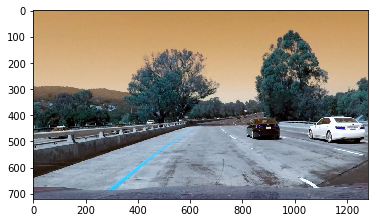

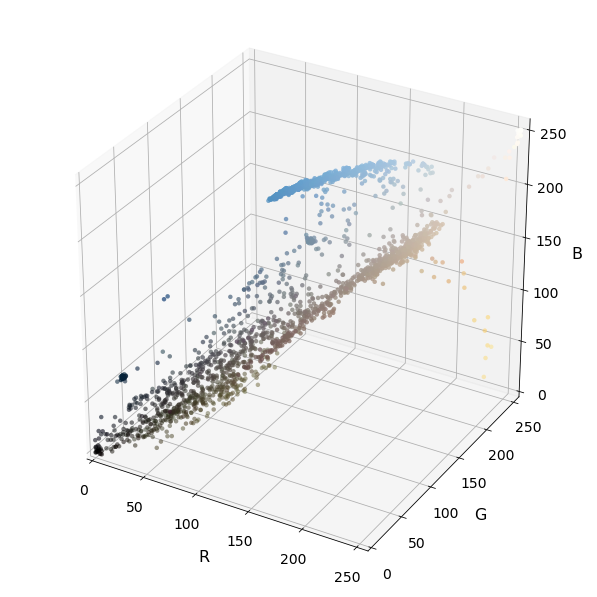

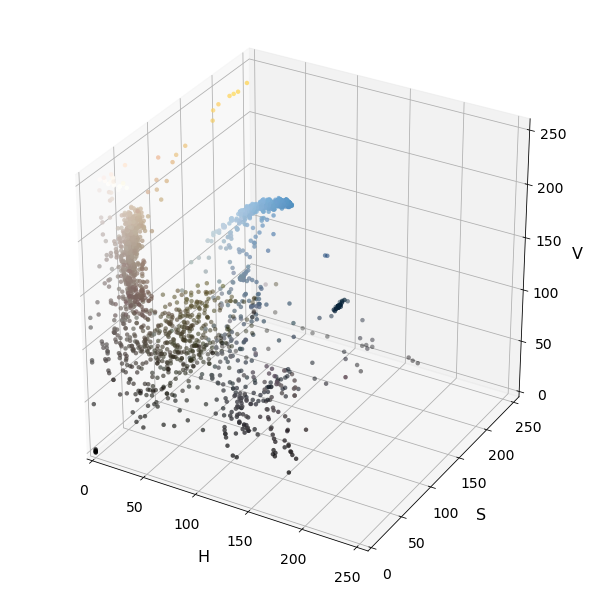

In [140]:

def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation


# Read a color image
img = cv2.imread(const_test_image_1)

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

plt.imshow(img)

# Plot and show
plot3d(img_small_RGB, img_small_rgb)
plt.show()

plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()




# Results of tweaking and trying various parameters, for a test image

* Tweaked one parameter at a time, recorded the results and see which ones gives the best results. 
    * Samples - Increased number of samples to 8000
    * Color Space :
        * All else being equal, HSV performed poorly relative to RGB in terms of false positives.
        * LUV was better than HSV but poorer than RGB.
        * HLS was better than HSV but poorer than RGB and LUV.
        * YUV comparable to RGB
        * YCrCb was slightly worse than RGB.
        * Based on the above results, I decided to proceed with RGB for the time - being. Alternative(s) could be YUV.
    * HoG orientations :
        * Started off with 9 - three false positives - FP.
        * 10 - eight FP.
        * 11 - two FP.
        * 13 - five FP.
        * 8 - four FP.
        * 7 - two FP.
        * 6 - eight FP.
        * Based on the above, I decided to proceed with 7 HoG orientations ( two FP ). Alternatives could be 11, or 9.
    * Pixel Per Cell :
        * Baseline - 8 - 2 FP.
        * 16 - 4 FP.
        * 32 - 6 FP.
        * 6 - 2FP.
        * 5 - 3 FP.
        * 4 - 5 FP.
        * Decision: 1. Go with 8 2. Backup(s) - 6.
    * Cells per Block :
        * Baseline - 2 cells per block - 2 FP.
        * 4 - 3 FP.
        * 8 - 3 FP.
        * 1 - 2 FP.
        * Decision : 1 cell per block. 2. Backup(s) - 2.
    * HoG Channel :
         * Baseline - 0 - 2 FP.
         * 1 - 11 FP.
         * 2 - 11 FP.
         * ALL - 4 FP.
         * Decision - 0 2. Backup(s) - All.
    * Spatial Size and hist_bins :
         * 16 x 16 and 16 - 1 FP.
         * 32 x 32 and 16 - 5 FP.
         * 8 x 8 and 8 - 1 FP.
         * 4 x 4 and 4 - 5 FP.
         * Decision - 16 x 16 and 16 2. Backup(s) - 8 x 8 and 8.
    * Only Spatial Features On:
        * 6 FP.
    * Only Histogram Features On:
        * 20 FP.
    * Only HoG Features On:
        * 4 FP. Also positive detection was not that strong.
    * Combinations of On Features:
        * spatial_feat, hog_feat
        * spatial_feat, hist_feat, hog_feat
    * X_Start_Stop
        * [200, image_width] = 0 FP.
 

